# Peep Show Text Analysis
### Exploring both external dialogue and internal monologue and how these differ during the series 

Thomas Bowe

## Introduction
I have previously processed all transcripts for the cult British comedy TV show Peep Show and now take the opportunity to analyse the text in great detail.

For anyone familiar with Peep Show, you know the main characters Mark and Jeremy (Jez) regularly use their internal monologue to progress the storyline. This is quite unique, and I am keen to analyse this aspect in detail.

#### I will explore the following topics:

1. Who are the primary characters and to what extent are Mark and Jeremy dominant?
2. What was the overall trend in line frequency for the main 6 characters?
3. What was the frequency of the top 25 unigrams (words) overall?
4. Using the Tidy Text TF-IDF function, what were the most ***unique*** words used by each of the main 6 characters?
5. What was the relative frequency of internal monologue vs external monologue for Mark and Jeremy?
6. Was there a trend to the internal monologue frequency over the duration of the series?
7. Was there a difference in the distribution of sentiment for Mark and Jeremy's internal monologue vs their external dialogue?
8. Again, using the TF-IDF function, what were the most ***unique*** words used in Mark and Jeremy's internal monologue when compared with their normal dialogue?
9. I then visualise the rate at which a word would be internalised vs externalised using a funnel plot and detect any outliers.
10. What was the overall sentiment of Peep Show using the Bing Lexicon?
11. What was the overall trend in sentiment by episode? Do any episodes stand out?
12. I then produce a detailed view of the sentiment trend by Mark and Jeremy's dialogue vs monologue.
13. What made the episode "Nether Zone" so negative for both Mark and Jeremy?
14. What made Jeremy so negative (and Mark so positive) in the episode "Jeremy's Mummy"?
15. I attempt to use a funnel plot to detect statistically significant character sentiment outliers I.e. I find out who the most negative and most positive characters are in relation to the average sentiment of the whole series.
16. I use the NRC Lexicon to determine the emotions of the main characters. Who was the angriest, the most fearless, the saddest, the most joyful? etc.
17. I then do some text mining and pull out trigrams and quadrigrams and ask which trigrams were ***unique*** to internal monologue, and what quadrigrams did Jeremy and Mark use the most?

In [1]:
install.packages("RWeka")
library(tidyverse)
library(kableExtra)
library(IRdisplay)
library(scales)
library(ggrepel)
library(tm)
library(tidytext)
library(ggthemes)
library(koRpus)
library(RWeka)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RWekajars’, ‘rJava’


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


The following object is masked from ‘package:httr’:

    content


Lo

In [25]:
# Create the figure height function for use in each plot
fig_height <- function(height) {
  options(repr.plot.width = 15, repr.plot.height = height)
}

# Create the core theme function
theme_tb <- function() {
  theme(
    axis.text = element_text(size = 18),
    plot.title = element_text(size = 28),
    plot.subtitle = element_text(size = 14),
    plot.caption = element_text(size = 14),
    panel.background = element_blank(),
    plot.background = element_rect(fill = "#FBF7EE", colour = "#FBF7EE"),
    axis.ticks = element_blank(),
    axis.title = element_text(size = 18),
    strip.text = element_text(size = 18, hjust = 0, face = "bold"),
    strip.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )
}

# Create the horizontal grid theme function
theme_tb_vert <- function() {
  theme( 
    panel.grid.major.x = element_line(colour = "grey", size = 0.2),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank()
  )
}

# Create the vertical grid theme function
theme_tb_hori <- function() {
  theme( 
    panel.grid.major.y = element_line(colour = "grey", size = 0.2),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank()
  )
}

# Create the both direction grid theme function
theme_tb_both <- function() {
  theme( 
    panel.grid.major = element_line(colour = "grey", size = 0.2)
  )
}

# Define the caption for each chart
capt <-
  "Source: https://transcripts.fandom.com/wiki/Peep_Show\n2021 | Data Visualisation by Tom Bowe"

top6characters <- c("Mark","Jeremy","Sophie","Super Hans","Dobby","Alan")

ps <- 
  read.csv("../input/peep-show-scripts/peepshow.csv") %>% subset(character != "Directions") %>%
# Remove anything contained in square brackets assumed to be direction content as I am only interested in dialogue
  mutate(content = str_replace_all(content, "\\[.*?\\]", ""))

# Import afinn lexicon
afinn <- 
  read.csv("../input/bing-nrc-afinn-lexicons/Afinn.csv")

# Import nrc lexicon
nrc <- 
  read.csv("../input/bing-nrc-afinn-lexicons/NRC.csv")

In [3]:
# Preview data
head(ps) %>%
  kbl("html") %>%
  kable_minimal("hover") %>%
  as.character() %>%
  display_html()

index,episode_index,season_number,episode_number,episode_name,episode_date,character,content
2,1,Season 1,Episode 1,Warring Factions,19/09/2003,Jeremy,"(This is fucking wicked. I am almost definitely a musical genius). . (Maybe a tattoo on my chest, but of my face. Yeah, double me! Feel it!)"
4,1,Season 1,Episode 1,Warring Factions,19/09/2003,Mark,"(She's on there, she's on there. Got to get the same bus home. Don't go! Almost there. Yes, I am the lord of the bus, said he! Where is she? Knickers! She's not on here...)"
5,1,Season 1,Episode 1,Warring Factions,19/09/2003,Sophie,Hey Mark!
6,1,Season 1,Episode 1,Warring Factions,19/09/2003,Mark,Sophie!
7,1,Season 1,Episode 1,Warring Factions,19/09/2003,Sophie,We must stop meeting like this.
8,1,Season 1,Episode 1,Warring Factions,19/09/2003,Mark,I was running. Were you running?


# Who Were the Primary Characters?
First, I get a feel for just how dominant Mark and Jeremy's dialogue is going to be in the data compared to other major characters:

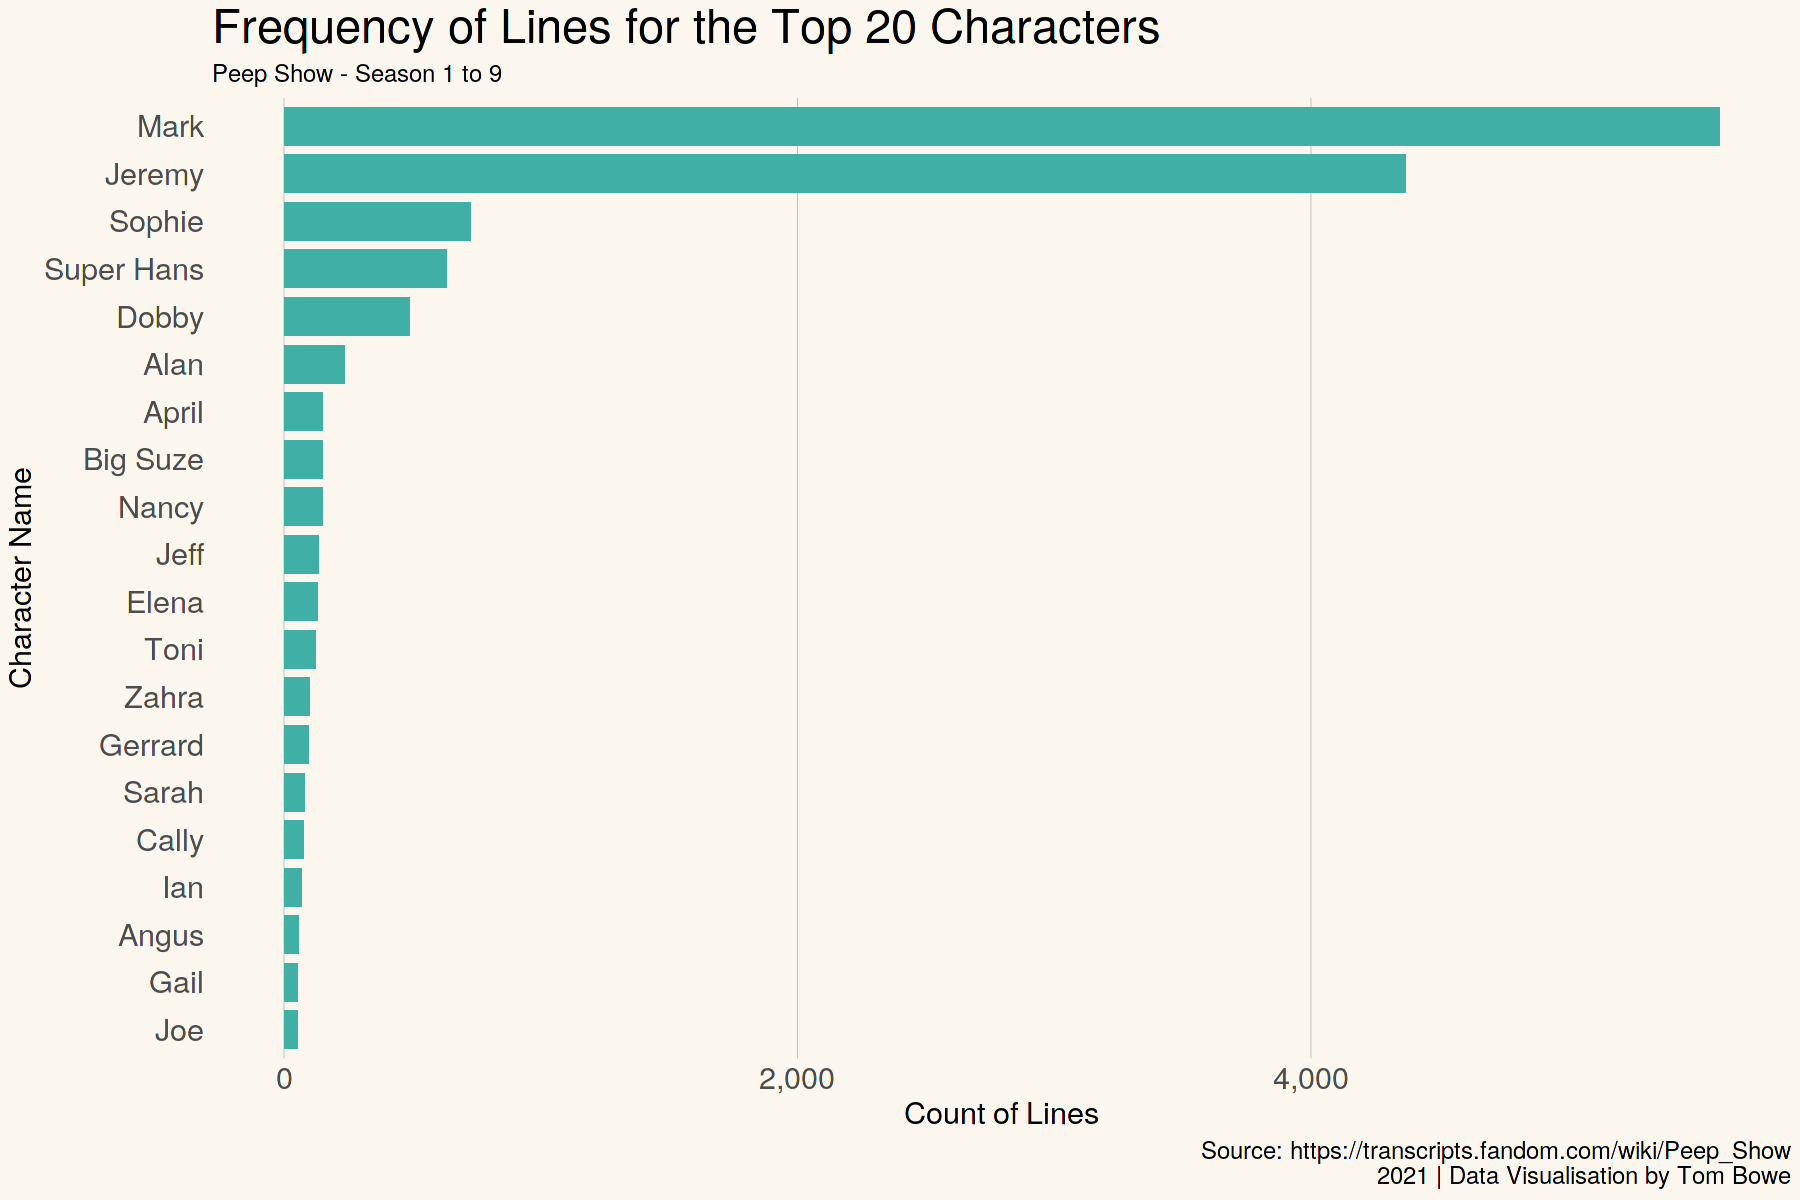

In [26]:
# Arrange the data:
psc <-
  count(ps, character, sort = TRUE) %>%
  slice(1:20)

# Visualise:
fig_height(10)
ggplot(psc, aes(x = reorder(character, n), y = n)) +
  scale_y_continuous(labels = comma) +
  geom_bar(stat = "identity",
           fill = "#40B0A6",
           width = 0.8) +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(
    y = "Count of Lines",
    x = "Character Name",
    title = "Frequency of Lines for the Top 20 Characters",
    subtitle = "Peep Show - Season 1 to 9",
    caption = capt
  )

# Trend of Line Frequency for Main Characters
Let's take a look at how the top 5 character's lines present over time. I've plotted below each of these characters and the frequency of lines they had relative to each other over each episode from season 1 to season 9.

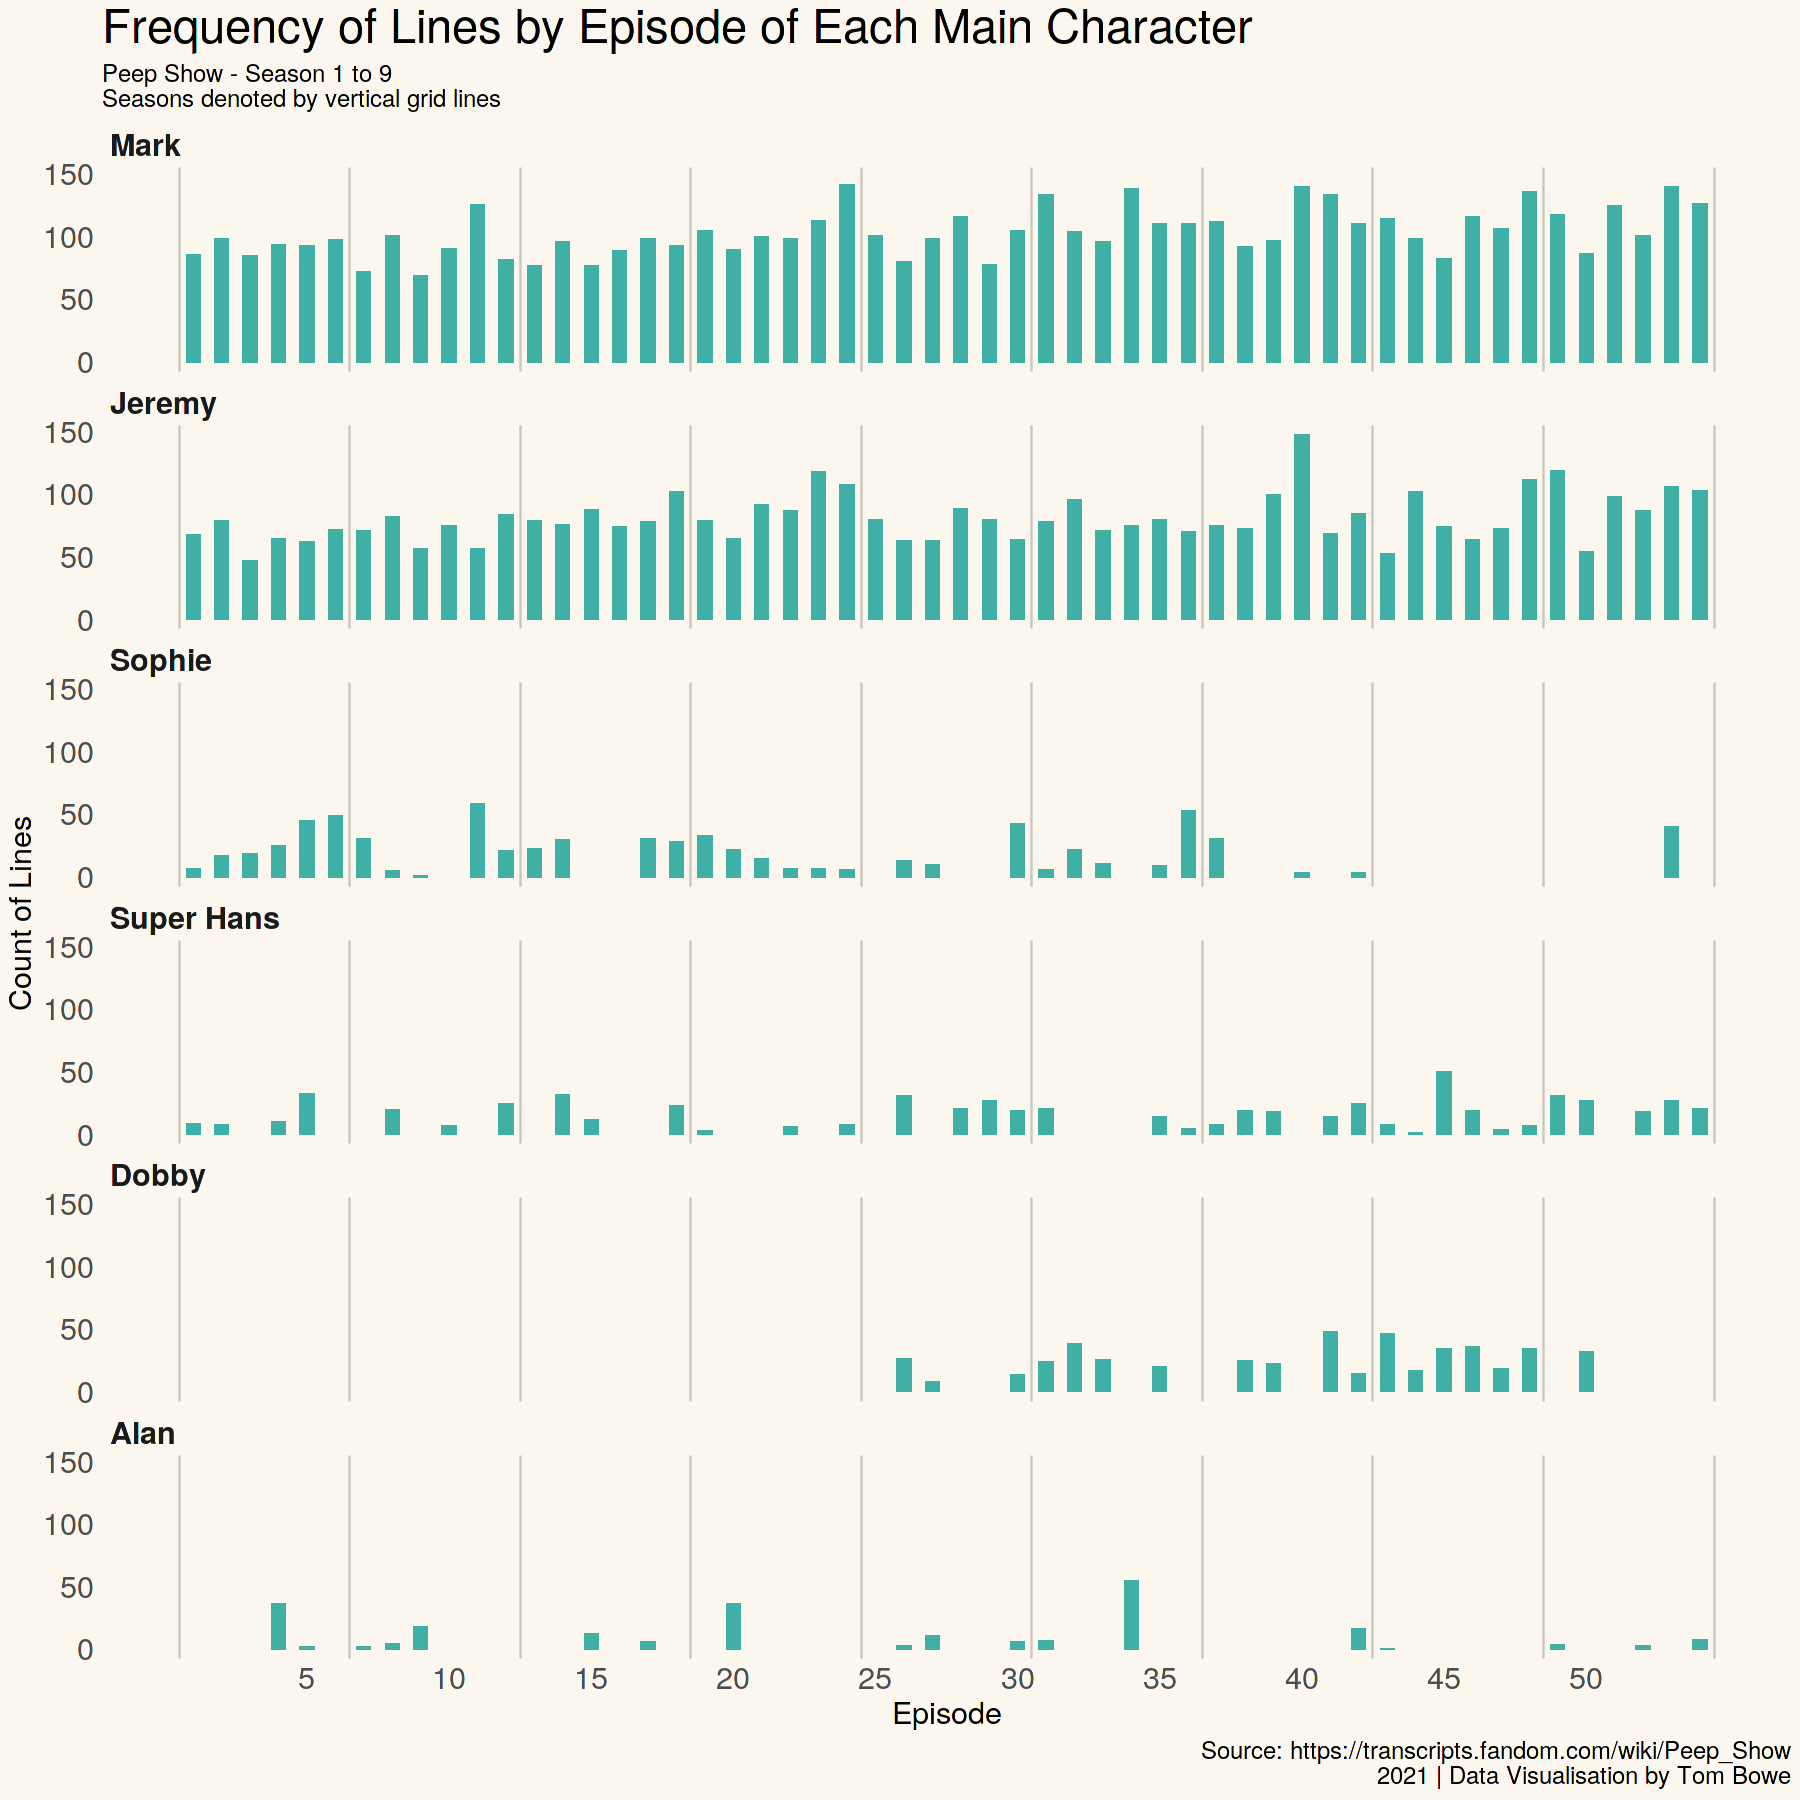

In [27]:
# Arrange the data:
psmc <-
  subset(ps,
         character %in% top6characters) %>%
  transform(character = factor(character, levels = top6characters))

# Visualise:
fig_height(15)
ggplot(psmc, aes(x = episode_index)) +
  geom_vline(xintercept = seq(.5, 54.5, 6),
             col = 1,
             alpha = .2) +
  geom_bar(fill = "#40B0A6", width = .5) +
  scale_x_continuous(breaks = seq(from = 5, to = 50, by = 5)) +
  theme_tb() +
  facet_wrap( ~ character, ncol = 1) +
  labs(
    y = "Count of Lines",
    x = "Episode",
    title = "Frequency of Lines by Episode of Each Main Character",
    subtitle = "Peep Show - Season 1 to 9\nSeasons denoted by vertical grid lines",
    caption = capt
  )

# Frequency of the Top 25 Unigrams
I tidy up the data removing any stop words and other junk that will pollute the insights. Now I first take a look at the most common unigrams (single words) that are contained in Peep Show dialogue to get an idea of what I am working with:

In [20]:
# Divide the entire dataset into internal and external dialogue
psexternal <- 
  mutate(ps, content = str_replace_all(content, "\\(.*?\\)", " "), dialogue_type = "External")
  
psinternal <- 
  mutate(ps, content = str_replace_all(content, "[^\\)]+(\\(|$)", " "), dialogue_type = "Internal")

# Remove stop words, punctuation, and excess spaces
psclean <-
  rbind(psexternal, psinternal) %>%
  subset(content != "") %>%
  mutate(content = tolower(content)) %>%
  mutate(content = str_replace_all(content, "i'll", "ixxxxxxl")) %>%
  mutate(content = removePunctuation(content)) %>%
  mutate(content = str_replace_all(content, "ixxxxxxl", "i'll")) %>%
  mutate(content = removeWords(content, stopwords("en"))) %>%
  mutate(content = removeWords(content,
    c(
      "thats","weve","hes","theres","ive","im","will","can","cant","dont",
      "youve","us","youre","youll","theyre","whats","didnt","id"
    )
  )) %>%
  mutate(content = str_squish(content)) %>%
  mutate(content = stripWhitespace(str_trim(content, side = "both"))) %>%
  mutate(content = str_replace_all(content, "super hans", "superxhans"))

# Create a table of unigrams
pstokenised <-
  separate_rows(psclean, content, sep = " ") %>%
  subset(content != "") %>%
  mutate(content = str_replace_all(content, "superxhans", "super hans"))

# Create the BING Lexicon data frame:
psbing <- 
  rename(pstokenised, word = content) %>%
  inner_join(get_sentiments("bing"), by = c("word" = "word"))

# Create the AFINN Lexicon data frame:
psafinn <- 
  rename(pstokenised, word = content) %>%
  inner_join(afinn, "word", by = c("word" = "word"))

# Create the NRV Lexicon data frame
psnrc <- 
  rename(pstokenised, word = content) %>%
  inner_join(nrc, "word", by = c("word" = "word"))

# Test that only Mark and Jeremy have internal dialogue
inttest <- 
  subset(pstokenised, dialogue_type == "Internal") %>%
  count(character, sort = TRUE) %>%
  rename(All_Characters = character, Internal_Word_Count = n) %>%
  kbl("html") %>%
  kable_minimal("hover") %>%
  as.character() %>%
  display_html()

All_Characters,Internal_Word_Count
Mark,16305
Jeremy,6706


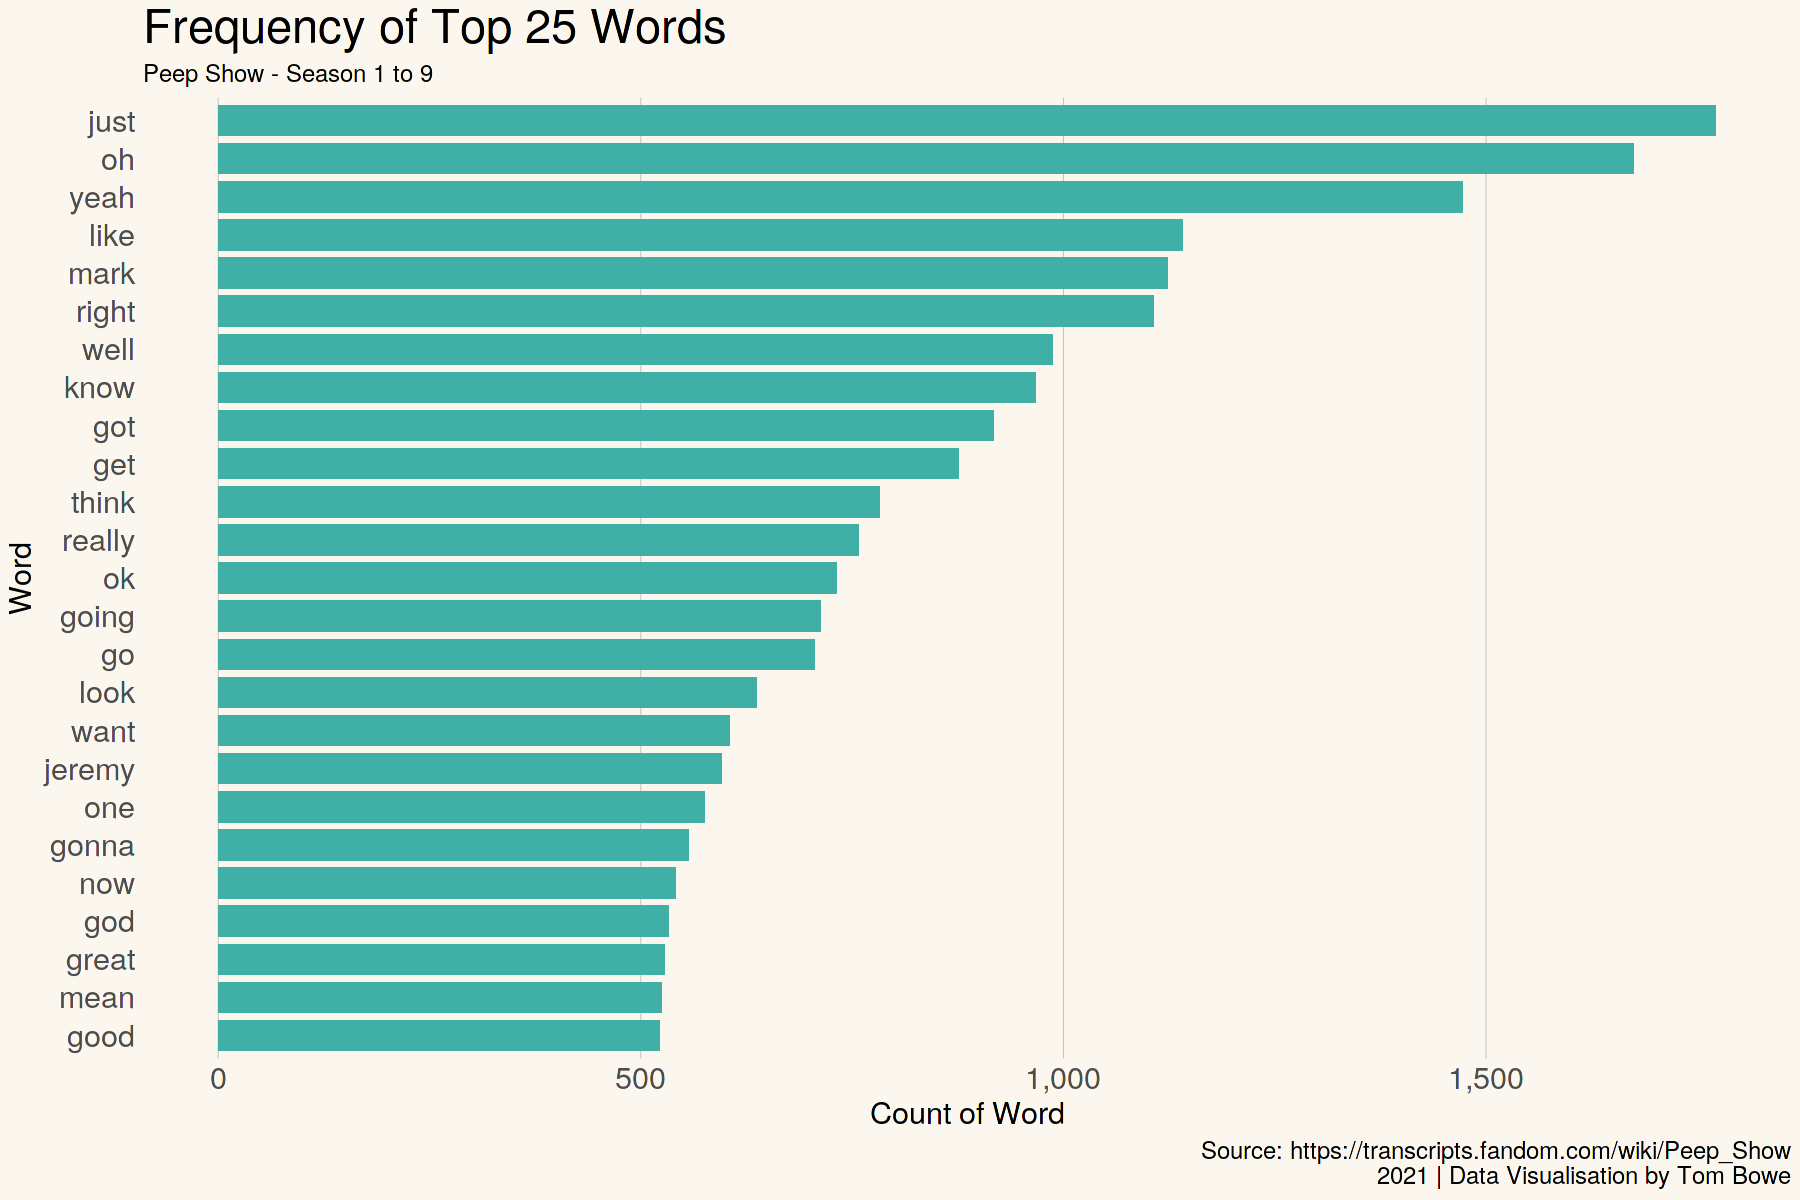

In [22]:
# Visualise:
fig_height(10)
ggplot(slice(count(pstokenised, content, sort = TRUE), 1:25), aes(x = reorder(content, n), y = n)) +
  scale_y_continuous(labels = comma) +
  geom_bar(stat = "identity",
           fill = "#40B0A6",
           width = .8) +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(
    y = "Count of Word",
    x = "Word",
    title = "Frequency of Top 25 Words",
    subtitle = "Peep Show - Season 1 to 9",
    caption = capt
  )

# The Main Character's Most Unique Words
Finding out the frequency at which a word was spoken is interesting, but it is not as interesting as determining the most unique or important words spoken by that character. Words that define the character, and that they use at a significantly greater rate than all other characters in the show.

To do this we use a technique called **Term Frequency - Inverse Document Frequency** and this will allow us to calculate a weight for each word used in Peep Show dialogue, for each of the main characters.

Applying this technique, we immediately see words that we can attribute to the characters quite easily: Sex is high on both Jez and Mark's list, while Sophie seems more focused on nanas cottage and getting an annulment. 25% of all Super Hans most unique words were drug related and we can see Project Zeus at the top of Alan's list as well.

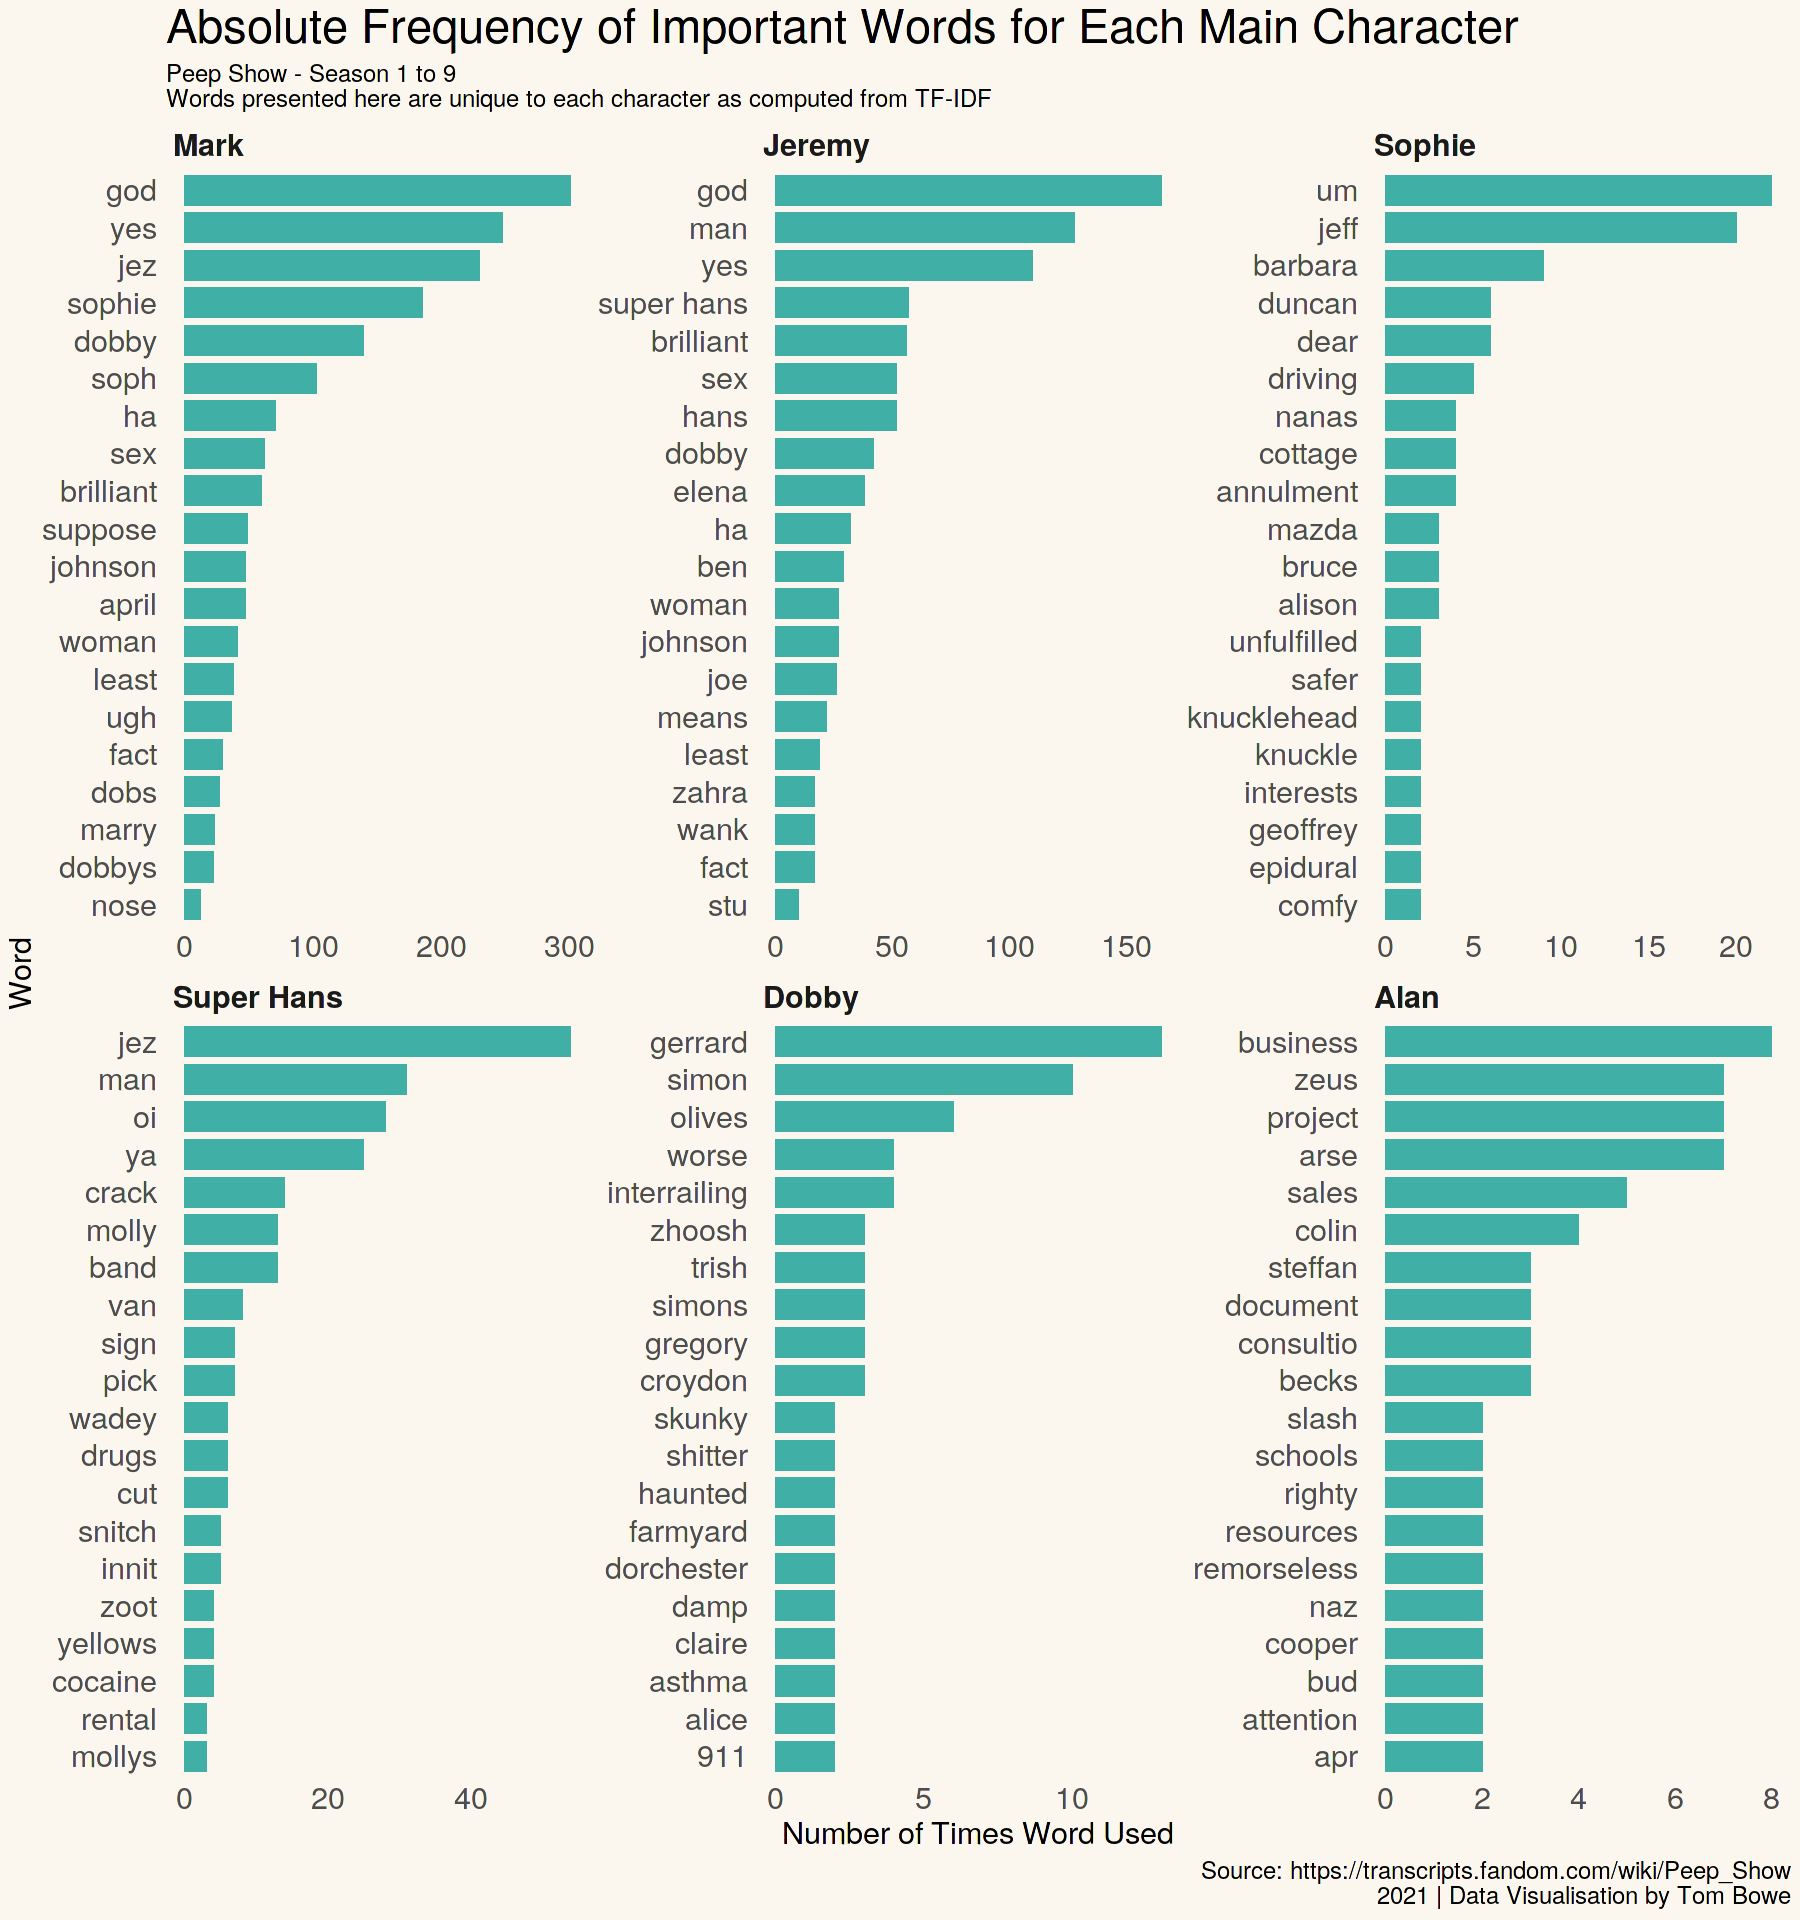

In [28]:
# Arrange data by calculating the TF-IDF
words <-
  count(pstokenised, character, content, sort = TRUE) %>%
  ungroup()

allwords <-
  group_by(words, character) %>%
  summarise(total = sum(n), .groups = 'drop')

words <-
  left_join(words, allwords, by = c("character" = "character")) %>%
  subset(character %in% top6characters) %>%
  bind_tf_idf(content, character, n)

wordsplt_mark <-
  subset(words, character == "Mark") %>%
  arrange(desc(tf_idf)) %>%
  slice(1:20)
wordsplt_jeremy <-
  subset(words, character == "Jeremy") %>%
  arrange(desc(tf_idf)) %>%
  slice(1:20)
wordsplt_sophie <-
  subset(words, character == "Sophie") %>%
  arrange(desc(tf_idf)) %>%
  slice(1:20)
wordsplt_superhans <-
  subset(words, character == "Super Hans") %>%
  arrange(desc(tf_idf)) %>%
  slice(1:20)
wordsplt_dobby <-
  subset(words, character == "Dobby") %>%
  arrange(desc(tf_idf)) %>%
  slice(1:20)
wordsplt_alan <-
  subset(words, character == "Alan") %>%
  arrange(desc(tf_idf)) %>%
  slice(1:20)

wordsplt <-
  rbind(
    wordsplt_mark,
    wordsplt_jeremy,
    wordsplt_sophie,
    wordsplt_superhans,
    wordsplt_dobby,
    wordsplt_alan
  ) %>%
  transform(character = factor(character, levels = top6characters))

# Visualise:
fig_height(16)
ggplot(wordsplt, aes(x = reorder_within(content, n, character), y = n)) +
  geom_bar(stat = "identity", fill = "#40B0A6", width = 0.8) +
  theme_tb() +
  scale_x_reordered() +
  facet_wrap( ~ character, scales = "free") +
  coord_flip() +
  labs(
    y = "Number of Times Word Used",
    x = "Word",
    title = "Absolute Frequency of Important Words for Each Main Character",
    subtitle = "Peep Show - Season 1 to 9\nWords presented here are unique to each character as computed from TF-IDF",
    caption = capt
  )

# Internal Monologue vs External Dialogue
We know that Mark and Jez are the only 2 characters in the show who have their internal monologues documented. This is incredibly unique and I want to thoroughly investigate the differences between each set of dialogue. I will go on now to explore:

* The extent at which each of them speak in their head
* The most significant words that are used internally vs externally
* The sentiment of internal monologues vs external dialogues
* Observe the trend of internal monologue throughout the series

### Extent at which Mark and Jez Use Internal Monologues 
From the below we can see that even with sheer volume of lines aside, Mark also says more in his head when compared to Jeremy.

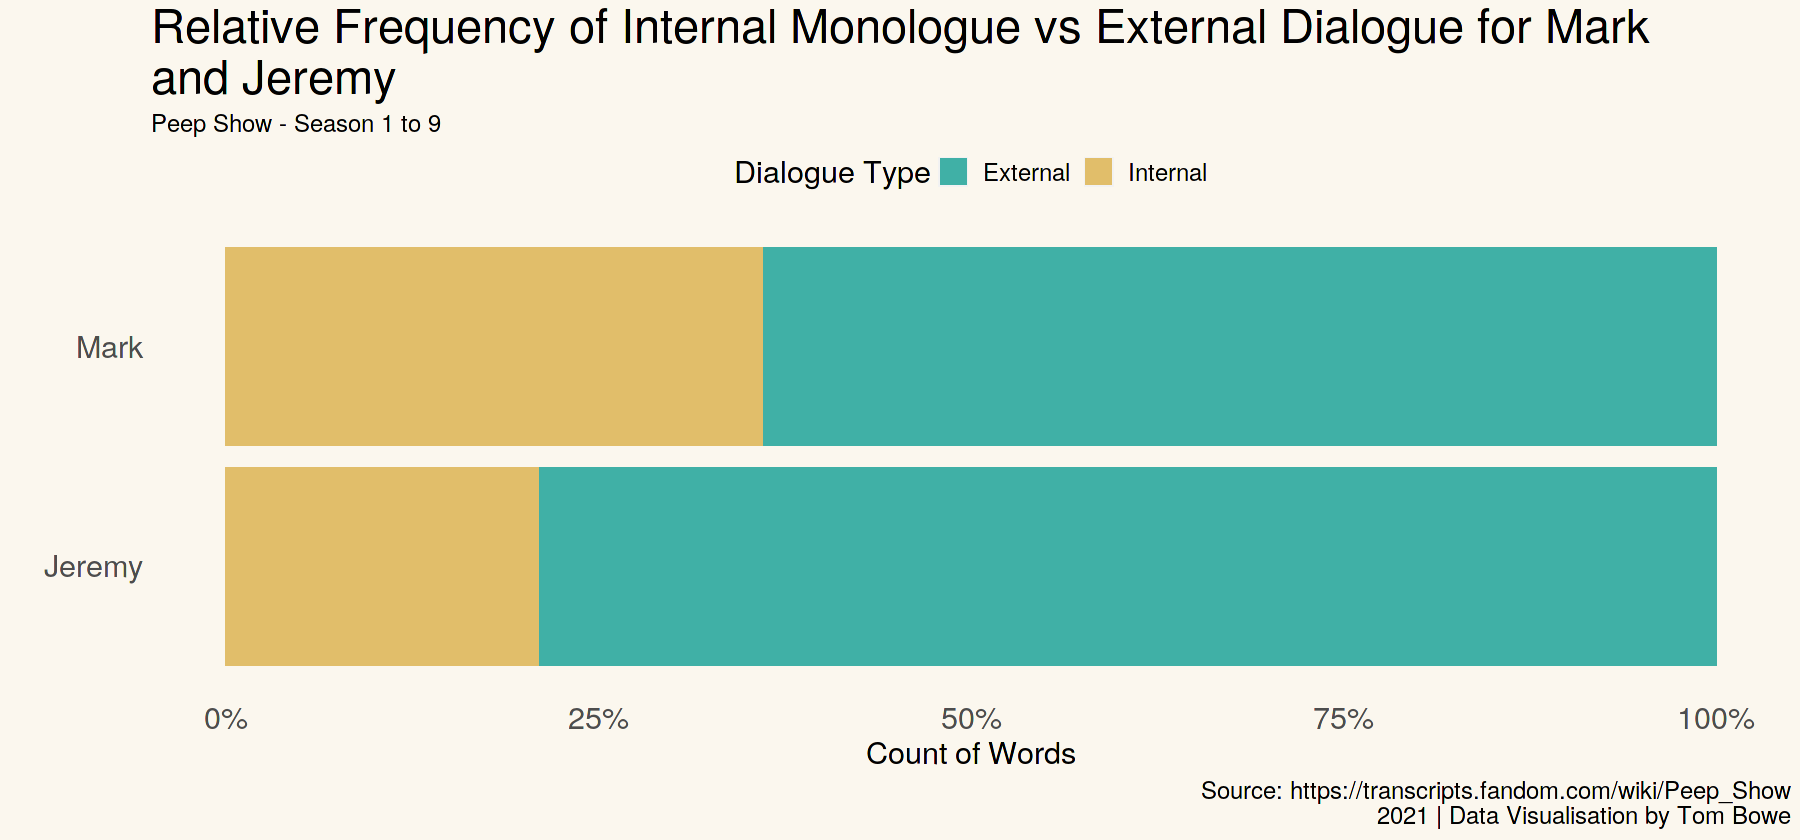

In [30]:
# Arrange the data:
pst <-
  count(pstokenised, character, dialogue_type, sort = TRUE) %>%
  slice(1:4)

# Visualise:
fig_height(7)
ggplot(pst, aes(
  x = reorder(character, n, sum),
  y = n,
  fill = dialogue_type
)) +
  scale_y_continuous(labels = percent_format()) +
  geom_bar(stat = "identity",
           position = "fill",
           width = .9) +
  theme(
    legend.title = element_text(size = 18),
    legend.position = "top",
    legend.background = element_blank(),
    legend.text = element_text(size = 14)
  ) +
  theme_tb() +
  scale_fill_manual(values = c("#40B0A6", "#E1BE6A"), name = "Dialogue Type") +
  coord_flip() +
  labs(
    y = "Count of Words",
    x = "",
    title = "Relative Frequency of Internal Monologue vs External Dialogue for Mark\nand Jeremy",
    subtitle = "Peep Show - Season 1 to 9",
    caption = capt
  )

### The Overall Trend of Internal Monologue Compared with External Dialogue
Here I track the frequency of internal monologue to check if any episodes were more focused on the thoughts of Mark and Jeremy compared to others. I adjust the alpha to identify each of the characters so Mark is the lighter of the two colours.

I do note in particular Season 2, Episode 1 "Dance Class" where nearly 50% is internal monologue and of that, it is mostly Mark. In this episode Mark hacks into Sophie's emails and decides to attend the same Rainbow Rhythms dance class as her.

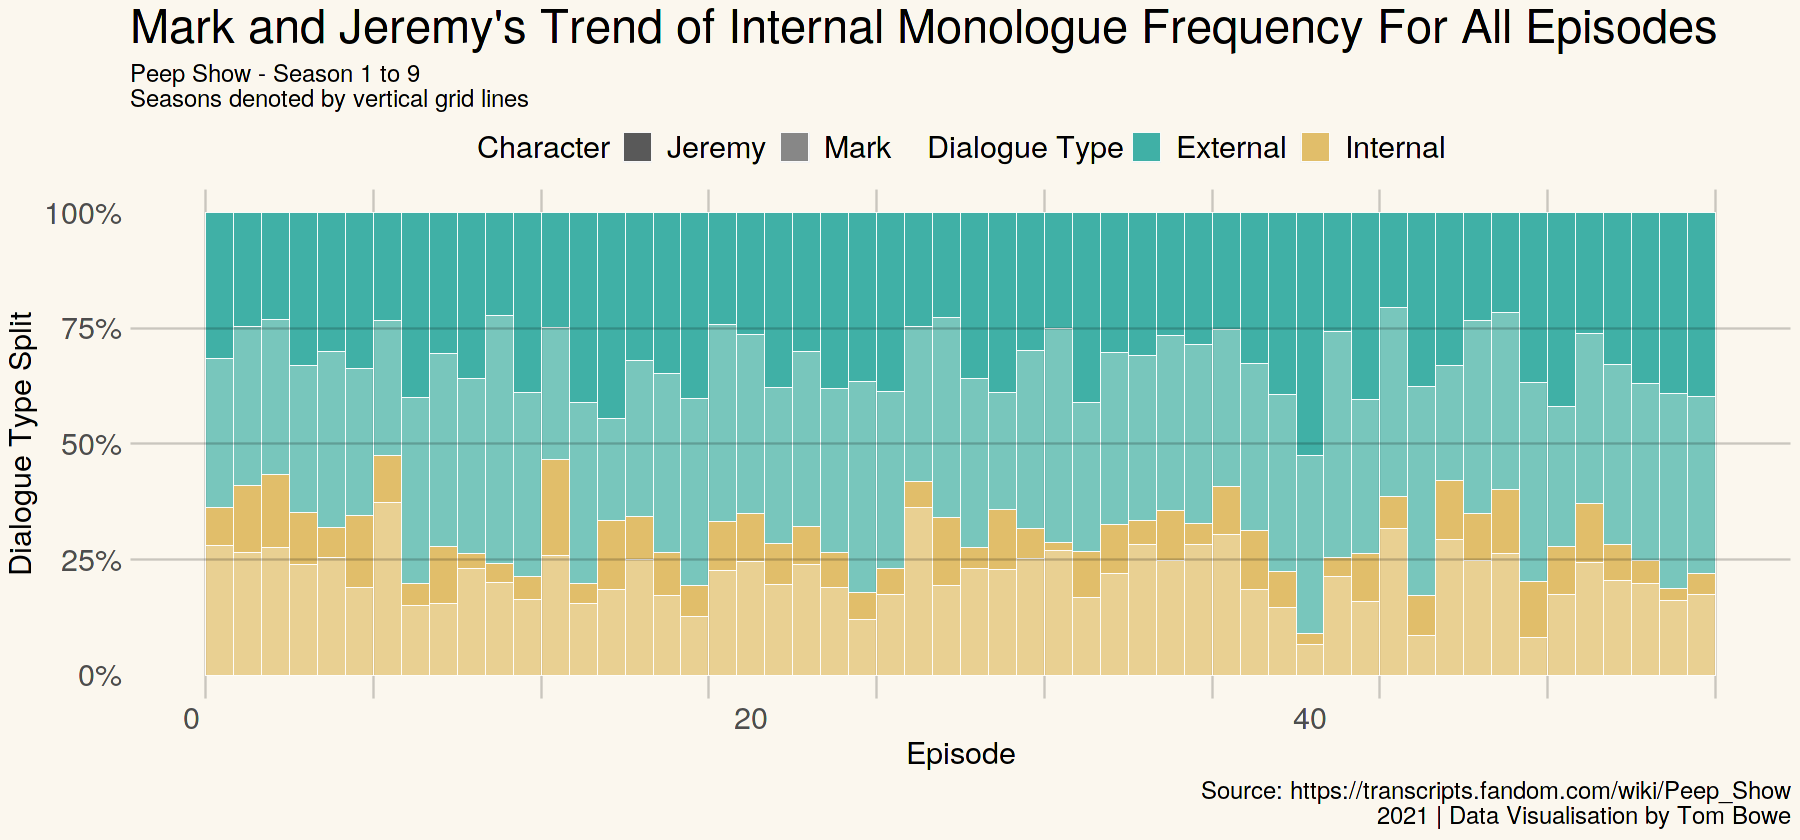

In [32]:
# Arrange the data:
ps_mono_trend <-
  subset(pstokenised, character %in% c("Mark", "Jeremy")) %>%
  count(season_number,
        episode_number,
        episode_index,
        character,
        dialogue_type,
        sort = FALSE)

# Visualise:
fig_height(7)
ggplot(ps_mono_trend,
       aes(
         x = episode_index,
         y = n,
         fill = dialogue_type,
         alpha = character
       )) +
  geom_vline(xintercept = seq(.5, 54.5, 6),
             col = 1,
             alpha = .2) +
  geom_bar(
    position = "fill",
    stat = "identity",
    colour = "white",
    size = 0.2,
    width = 1
  ) +
  geom_hline(yintercept = seq(.25, .75, .25),
             col = 1,
             alpha = 0.2) +
  scale_fill_manual(values = c("#40B0A6", "#E1BE6A"), name = "Dialogue Type") +
  scale_alpha_manual(values = c(1, .7), name = "Character") +
  scale_y_continuous(labels = percent_format()) +
  theme(
    legend.position = "top",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 18),
    legend.background = element_blank()
  ) +
  theme_tb() +
  labs(
    y = "Dialogue Type Split",
    x = "Episode",
    title = "Mark and Jeremy's Trend of Internal Monologue Frequency For All Episodes",
    subtitle = "Peep Show - Season 1 to 9\nSeasons denoted by vertical grid lines",
    caption = capt
  )

### The Sentiment Scores of Internal Monologue Compared with External Dialogue
Here I use the AFINN Lexicon to assign a sentiment score to words spoken by each character. A word will have a score from -5 to 5 representing its negativity or positivity respectively. I sum these scores for every word in an episode, by internal and external, and then draw a plot showing the density of sentiment for each.

Fascinatingly, for both characters, I note a more negative sentiment score mode for the internal monologue while external dialogue is more evenly spread and overall more positive. Jeremy's thoughts are more tightly distributed around a neutral to more positive sentiment compared to Mark's thoughts which are more spread out, both negatively, and positively.

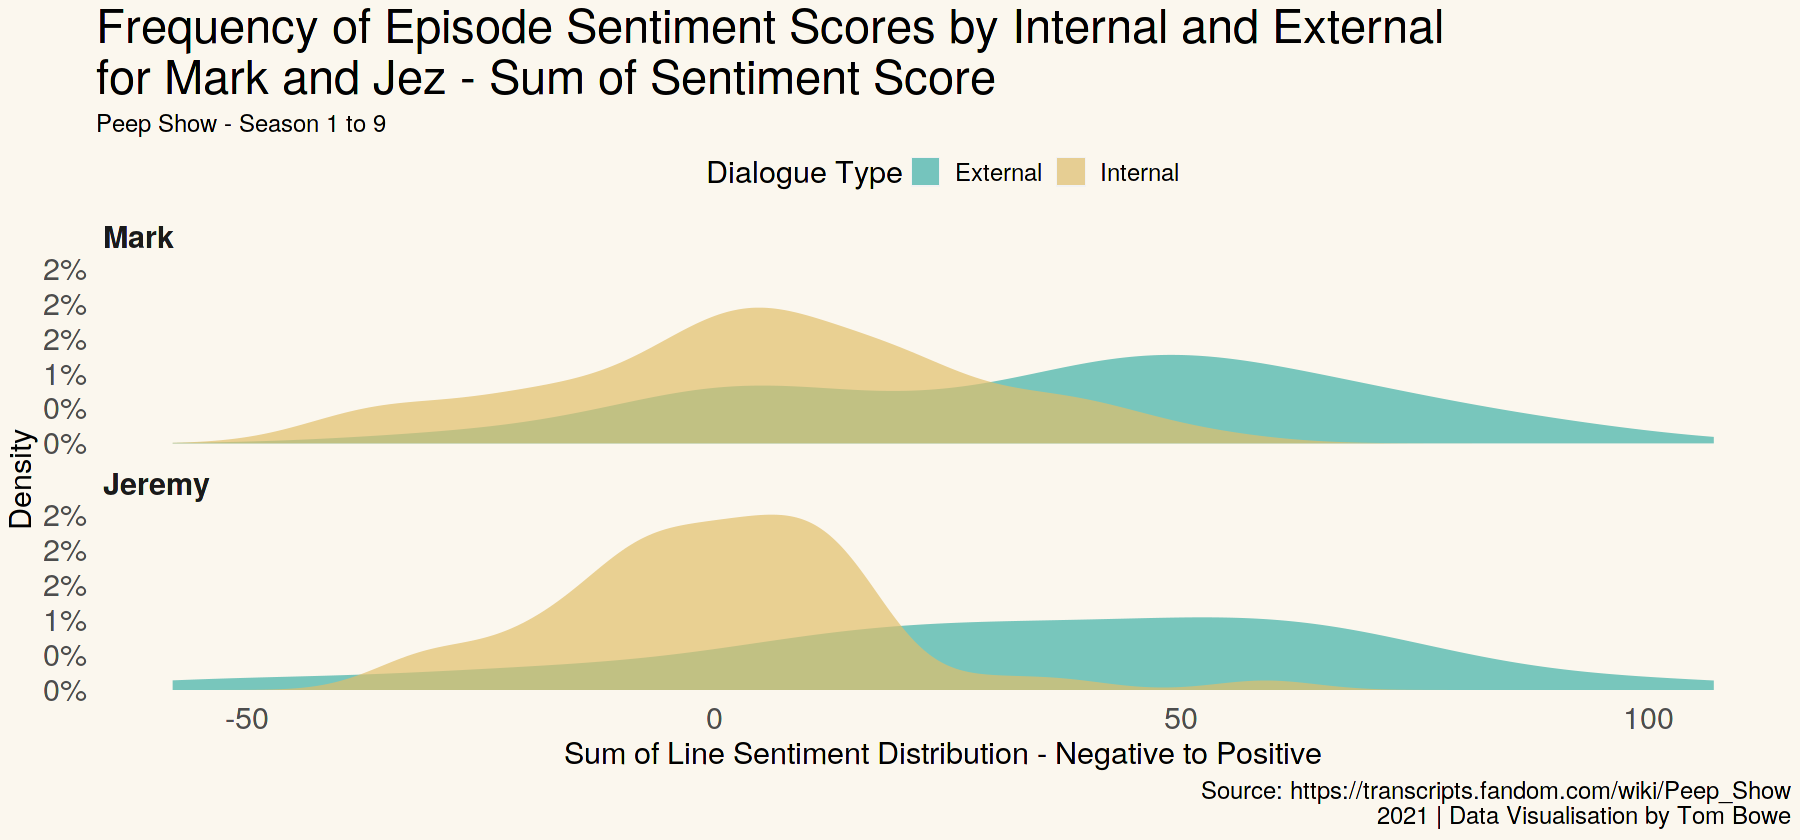

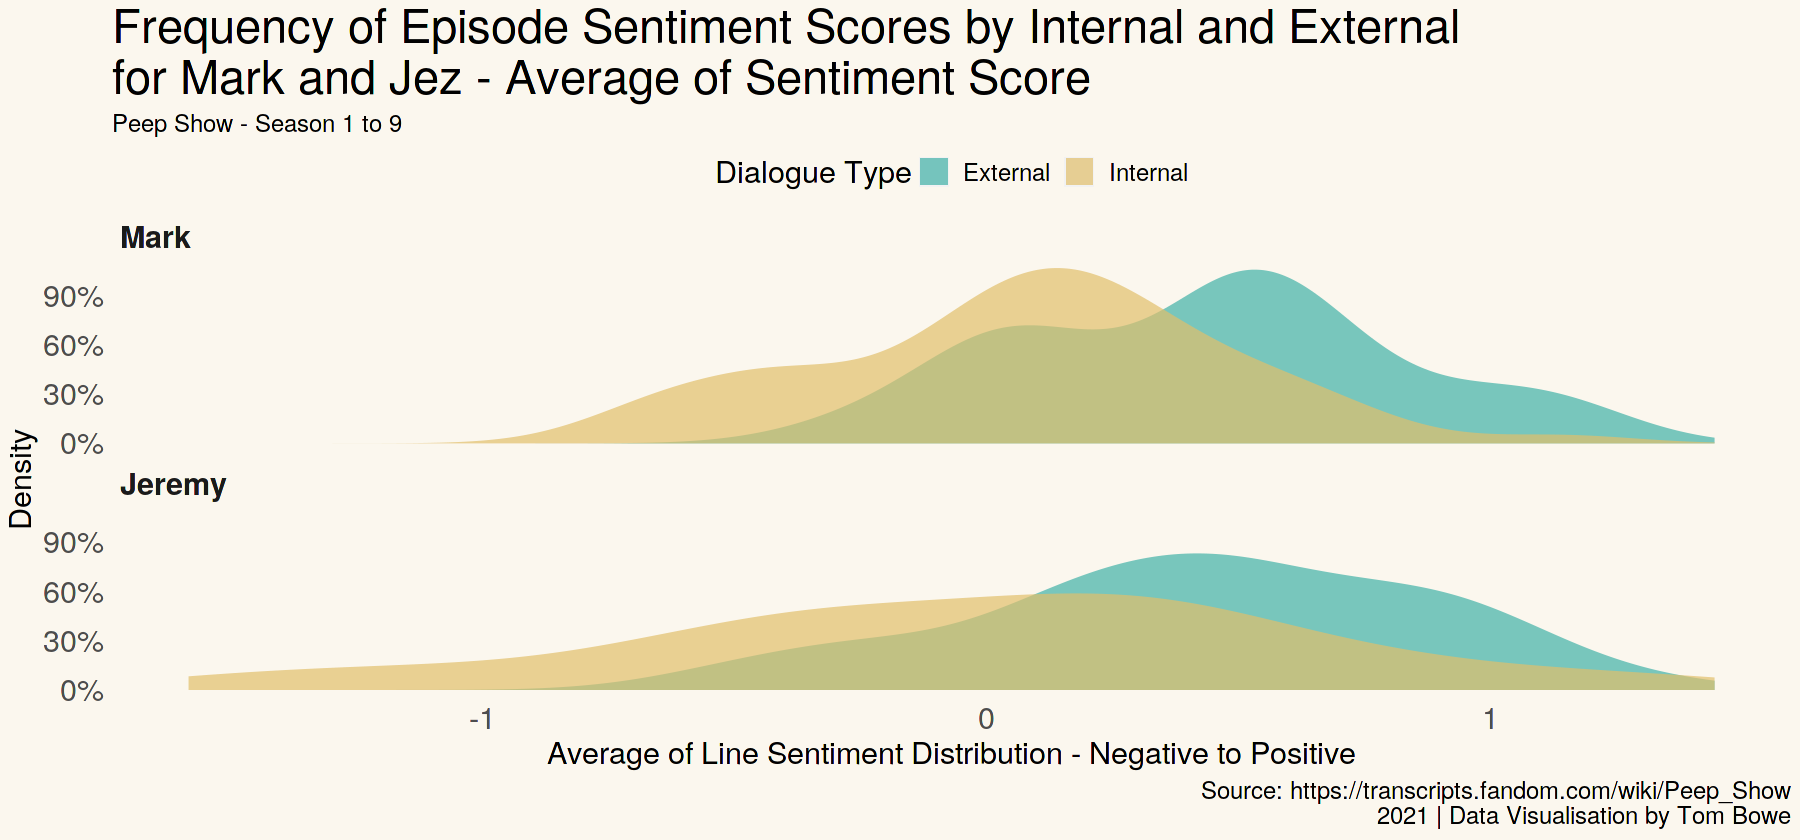

In [40]:
hist_sum <-
  aggregate(
    psafinn$value,
    by = list(
      line = psafinn$episode_index,
      character = psafinn$character,
      dialogue_type = psafinn$dialogue_type
    ),
    FUN = sum
  ) %>%
  subset(character %in% c("Mark", "Jeremy")) %>%
  transform(character = factor(character, levels = c("Mark", "Jeremy")))

hist_mean <-
  aggregate(
    psafinn$value,
    by = list(
      line = psafinn$episode_index,
      character = psafinn$character,
      dialogue_type = psafinn$dialogue_type
    ),
    FUN = mean
  ) %>%
  subset(character %in% c("Mark", "Jeremy")) %>%
  transform(character = factor(character, levels = c("Mark", "Jeremy")))

fig_height(7)
ggplot(hist_sum, aes(x = x, fill = dialogue_type)) +
  geom_density(alpha = 0.7,
               position = "identity",
               colour = NA) +
  theme(
    legend.title = element_text(size = 18),
    legend.position = "top",
    legend.background = element_blank(),
    legend.text = element_text(size = 14),
    plot.background = element_rect(fill = "#FBF7EE", colour = "#FBF7EE")
  ) +
  theme_tb() +
  facet_wrap( ~ character, ncol = 1) +
  scale_y_continuous(labels = percent_format(accuracy = 1L)) +
  scale_fill_manual(values = c("#40B0A6", "#E1BE6A"), name = "Dialogue Type") +
  labs(
    y = "Density",
    x = "Sum of Line Sentiment Distribution - Negative to Positive",
    title = "Frequency of Episode Sentiment Scores by Internal and External
for Mark and Jez - Sum of Sentiment Score",
    subtitle = "Peep Show - Season 1 to 9",
    caption = capt
  )

fig_height(7)
ggplot(hist_mean, aes(x = x, fill = dialogue_type)) +
  geom_density(alpha = 0.7,
               position = "identity",
               colour = NA) +
  theme(
    legend.title = element_text(size = 18),
    legend.position = "top",
    legend.background = element_blank(),
    legend.text = element_text(size = 14),
    plot.background = element_rect(fill = "#FBF7EE", colour = "#FBF7EE")
  ) +
  theme_tb() +
  facet_wrap( ~ character, ncol = 1) +
  scale_y_continuous(labels = percent_format(accuracy = 1L)) +
  scale_fill_manual(values = c("#40B0A6", "#E1BE6A"), name = "Dialogue Type") +
  labs(
    y = "Density",
    x = "Average of Line Sentiment Distribution - Negative to Positive",
    title = "Frequency of Episode Sentiment Scores by Internal and External
for Mark and Jez - Average of Sentiment Score",
    subtitle = "Peep Show - Season 1 to 9",
    caption = capt
  )

# Internal Monologue Outliers - Which Words are Unique to Internal Monologue?
I approach this via 2 methods:

* First, I apply the same TF-IDF technique I used to identify unique words used by each character, but instead of grouping by character, I group by the dialogue type I.e. Internal or External.

* I then create a comprehensive funnel plot that encodes the sentiment of each word as well. This approaches the same problem from a totally different direction. The funnel plot also finds words that were spoken more internally/externally and takes into account the law of small numbers where a word may not have been uttered often and therefore its rate of occurrence either externally or internally could have been entirely down to chance alone.

### TF-IDF
Using this technique reveals some interesting insights. Note that these words weren't necessarily frequent, but they were very unique to each document subset I.e. internal or external, when compared to the document in its entirety.

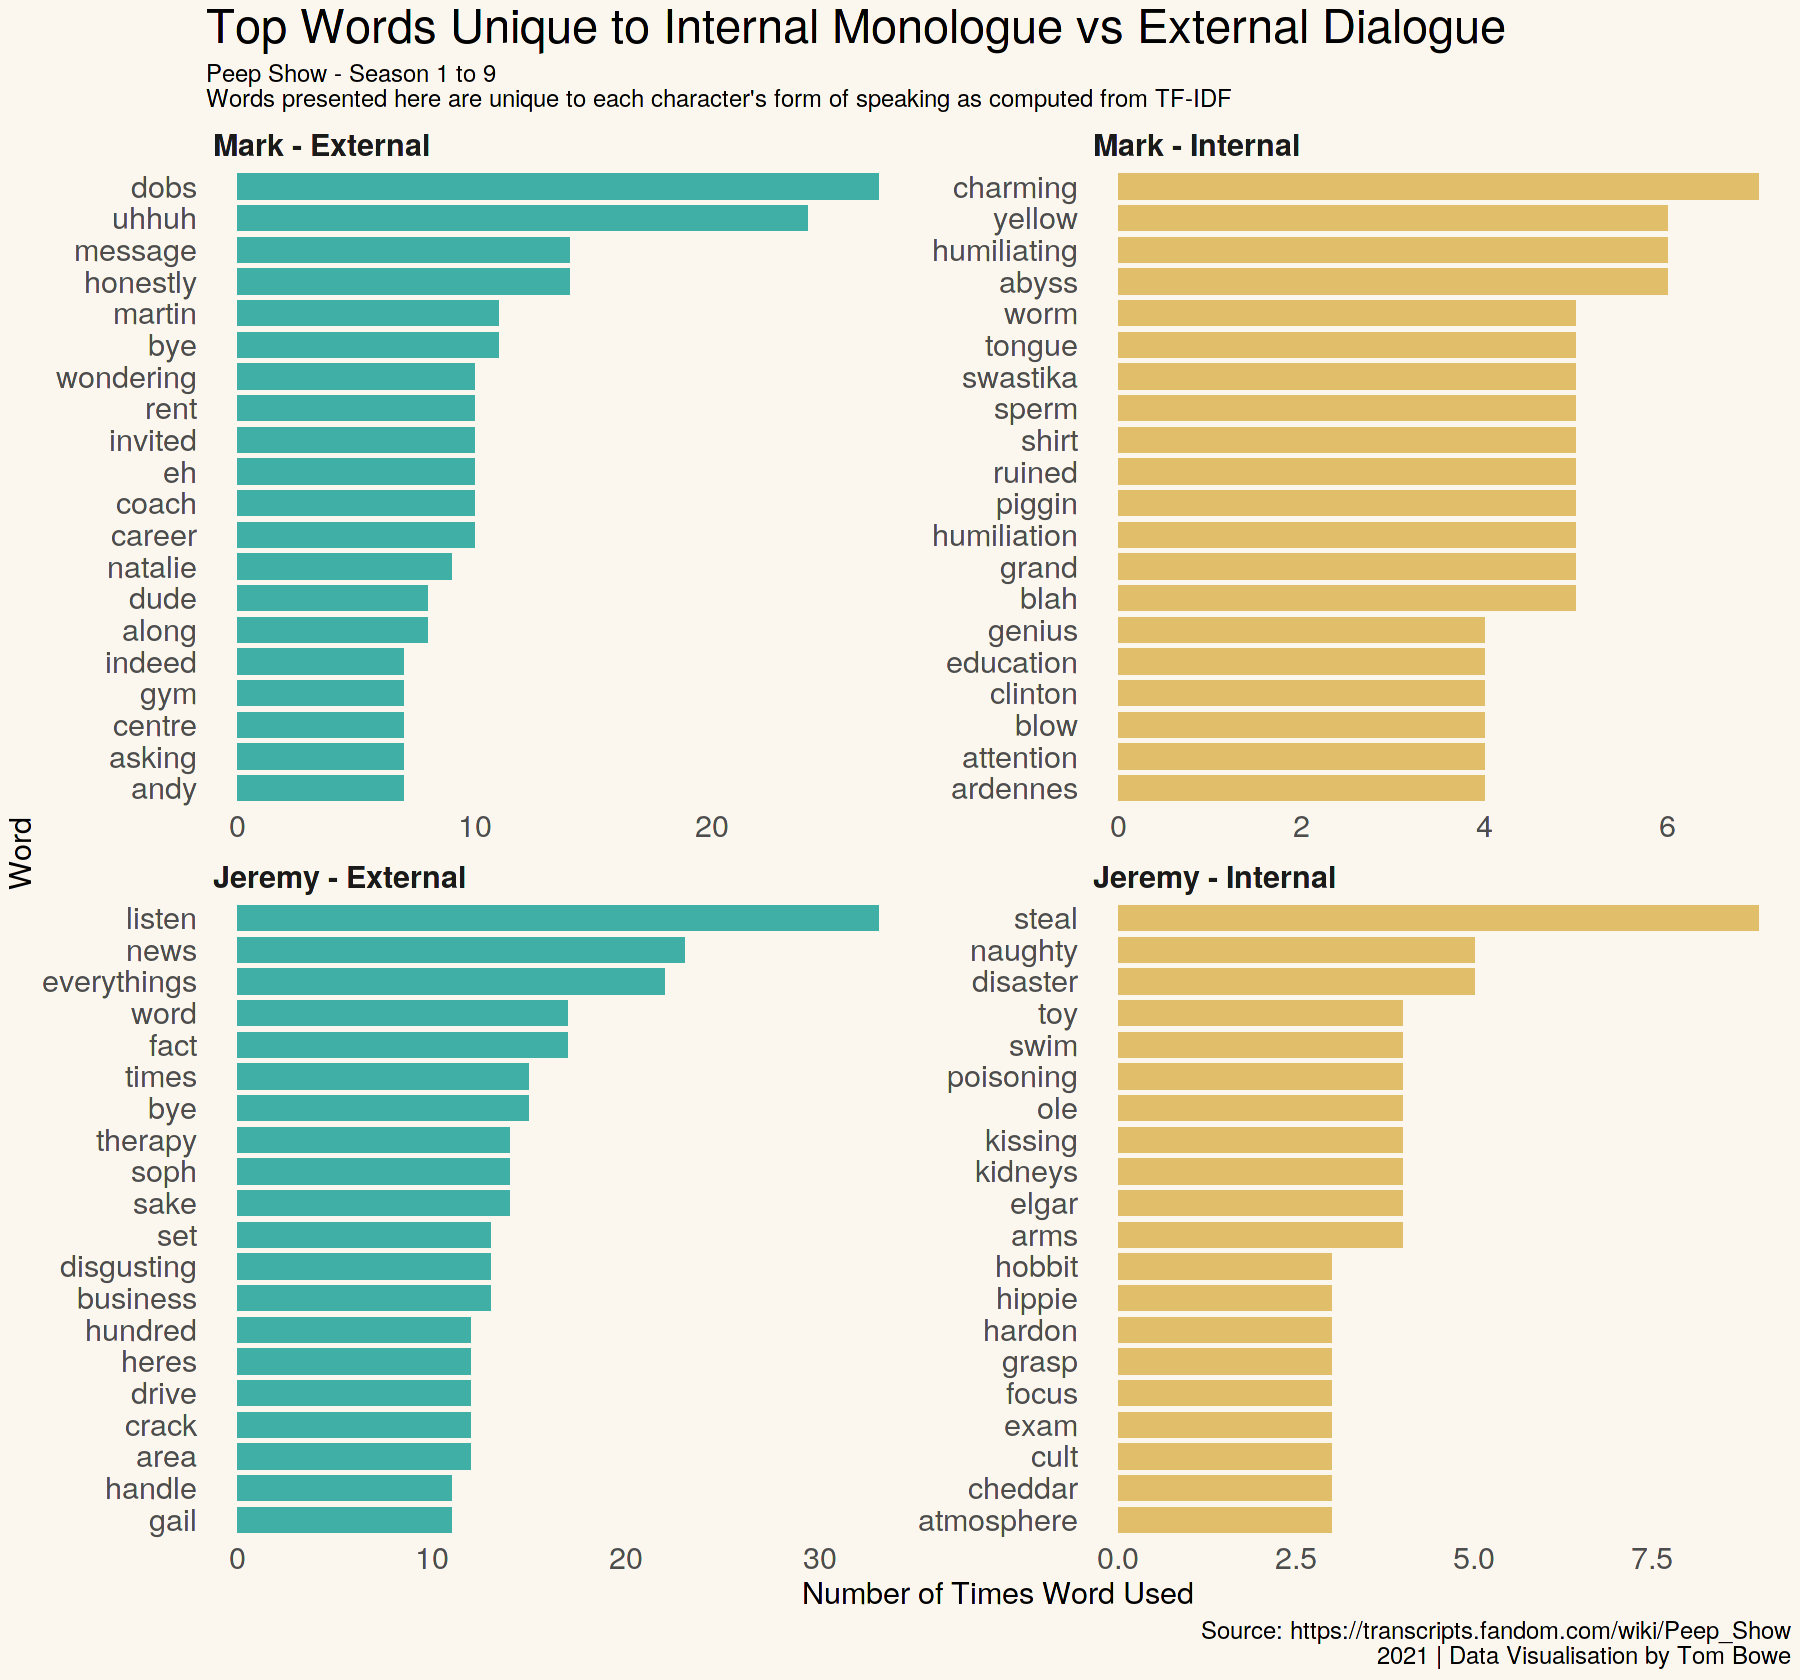

In [44]:
# Arrange the data for Mark
wordsintext_mark <-
  subset(pstokenised, character == "Mark") %>%
  count(dialogue_type, content, sort = TRUE) %>%
  ungroup()

allwordsintext_mark <-
  group_by(wordsintext_mark, dialogue_type) %>%
  summarise(total = sum(n), .groups = 'drop')

wordsintext_mark <-
  left_join(wordsintext_mark,
            allwordsintext_mark,
            by = c("dialogue_type" = "dialogue_type")) %>%
  bind_tf_idf(content, dialogue_type, n)

wordsintext_mark_plt_int <-
  subset(wordsintext_mark, dialogue_type == "Internal") %>% arrange(desc(tf_idf)) %>% slice(1:20)
wordsintext_mark_plt_ext <-
  subset(wordsintext_mark, dialogue_type == "External") %>% arrange(desc(tf_idf)) %>% slice(1:20)

wordsintext_mark_plt <-
  rbind(wordsintext_mark_plt_int, wordsintext_mark_plt_ext)

# Arrange the data for Jez
wordsintext_jez <-
  subset(pstokenised, character == "Jeremy") %>%
  count(dialogue_type, content, sort = TRUE) %>%
  ungroup()

allwordsintext_jez <-
  group_by(wordsintext_jez, dialogue_type) %>%
  summarise(total = sum(n), .groups = 'drop')

wordsintext_jez <-
  left_join(wordsintext_jez,
            allwordsintext_jez,
            by = c("dialogue_type" = "dialogue_type")) %>%
  bind_tf_idf(content, dialogue_type, n)

wordsintext_jez_plt_int <-
  subset(wordsintext_jez, dialogue_type == "Internal") %>% arrange(desc(tf_idf)) %>% slice(1:20)
wordsintext_jez_plt_ext <-
  subset(wordsintext_jez, dialogue_type == "External") %>% arrange(desc(tf_idf)) %>% slice(1:20)

wordsintext_jez_plt <-
  rbind(wordsintext_jez_plt_int, wordsintext_jez_plt_ext)

# Union the above data sets and create new categories to facet
wordsintext_plt_all <-
  rbind(
    mutate(wordsintext_mark_plt, character = "Mark"),
    mutate(wordsintext_jez_plt, character = "Jeremy")
  ) %>%
  mutate(category = paste(character, dialogue_type, sep = " - ")) %>%
  transform(category = factor(
    category,
    levels = c(
      "Mark - External",
      "Mark - Internal",
      "Jeremy - External",
      "Jeremy - Internal"
    )
  ))

# Visualise:
fig_height(14)
ggplot(wordsintext_plt_all,
       aes(
         x = reorder_within(content, n, category),
         y = n,
         fill = dialogue_type
       )) +
  geom_bar(stat = "identity", width = 0.8) +
  scale_fill_manual(values = c("#40B0A6", "#E1BE6A")) +
  theme(legend.position = "none") +
  theme_tb() +
  facet_wrap(~ category, scales = "free") +
  coord_flip() +
  scale_x_reordered() +
  labs(
    y = "Number of Times Word Used",
    x = "Word",
    title = "Top Words Unique to Internal Monologue vs External Dialogue",
    subtitle = "Peep Show - Season 1 to 9\nWords presented here are unique to each character's form of speaking as computed from TF-IDF",
    caption = capt
  )

### Funnel Plot
I use a funnel plot here to distinguish which words were significantly more frequent in internal monologue compared to external dialogue. I do an outer join on the Bing Lexicon to assign a sentiment, and anything without a sentiment I deem to be neutral. The TF-IDF approach does not discern between very infrequent words and the inherent random variation that would occur in these small samples. The funnel plot will give us a very comprehensive visual overview of each significant word and allow us to spot outliers.

I note that expressions of disgust and curse words are more likely to be uttered internally, while an apology is most likely to be spoken aloud. I also note Mark's use of *lovely* internally, most likely sarcastic but also when something finally goes well he may note this to himself.

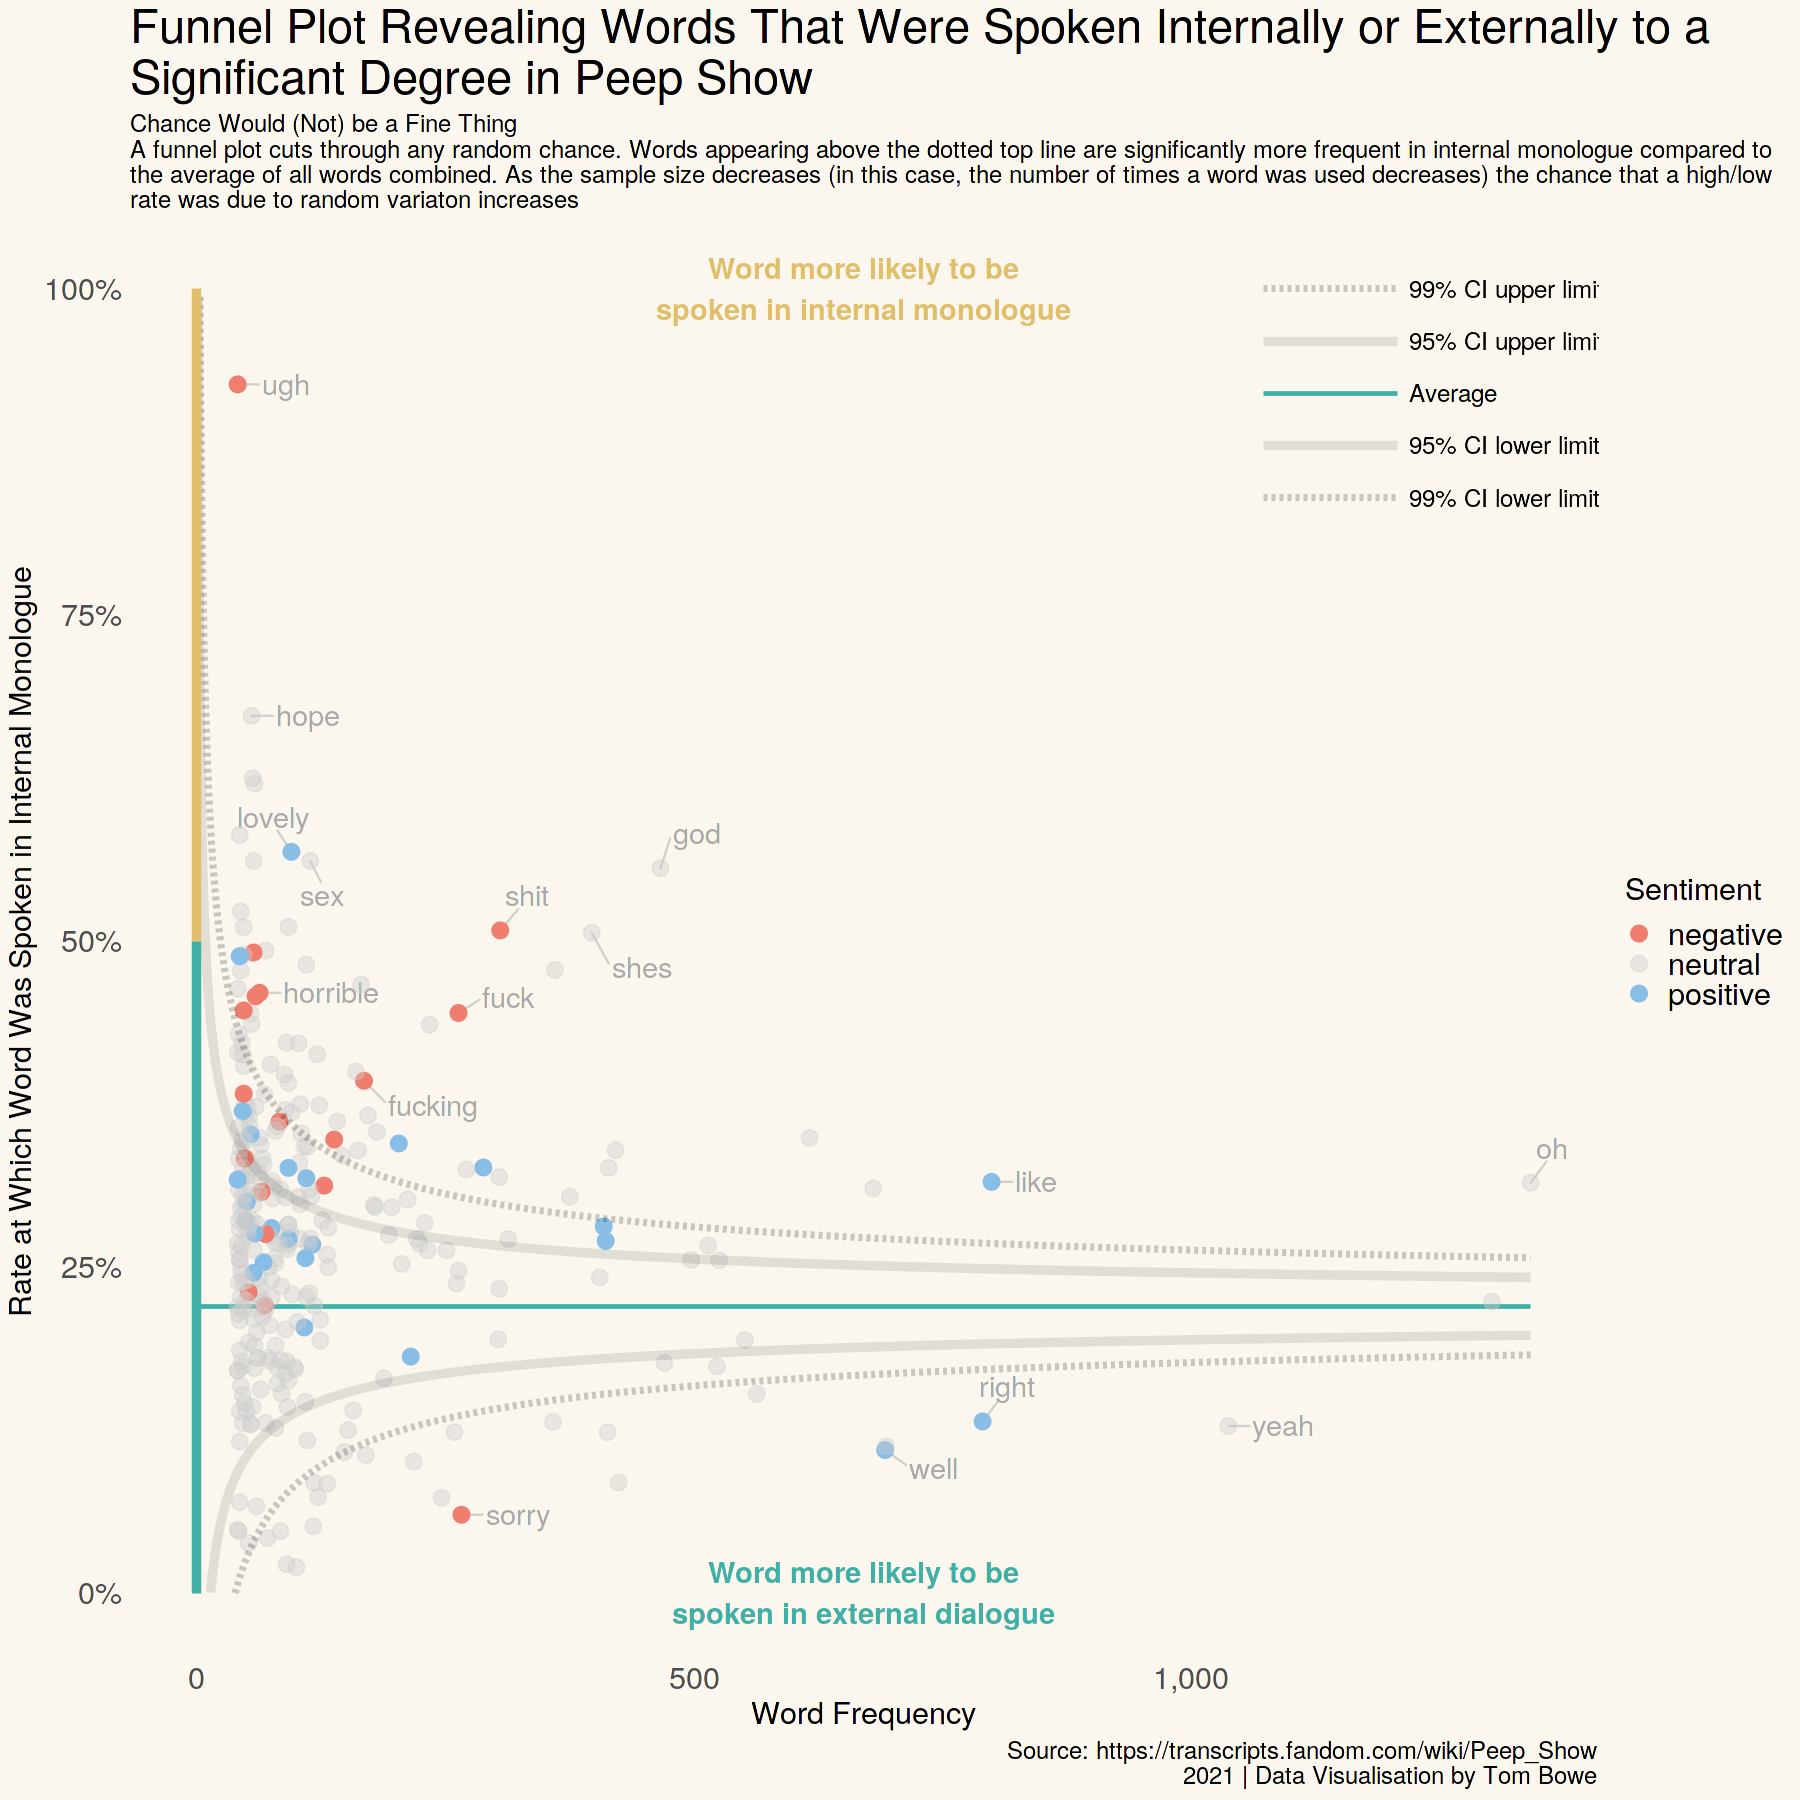

In [46]:
### Arrange the data
pop <-
  subset(pstokenised, character == "Mark" |
           character == "Jeremy") %>%
  count(content, dialogue_type, sort = TRUE) %>%
  pivot_wider(names_from = dialogue_type,
              values_from = n,
              values_fill = 0) %>%
  mutate(number = External + Internal,
         p = Internal / number,
         p.se = sqrt((p * (1 - p)) / (number))) %>%
  select(content, number, p, p.se) %>%
  rename(word = content) %>%
  subset(number > 40) %>%
  left_join(get_sentiments("bing"), by = "word") %>%
  mutate(sentiment = replace_na(sentiment, "neutral"))

write.csv(pop, "peepshow_dialogue_type_funnelplot.csv")

# Set boundaries of the chart
boundx <- max(pop$number)

# Create dataframes to draw legend
u99leg <-
  data.frame(
    x1 = (boundx / 5) * 4,
    x2 = (boundx / 5) * 4.5,
    y1 = 1,
    y2 = 1
  )
u95leg <-
  data.frame(
    x1 = (boundx / 5) * 4,
    x2 = (boundx / 5) * 4.5,
    y1 = 0.96,
    y2 = 0.96
  )
wmeanleg <-
  data.frame(
    x1 = (boundx / 5) * 4,
    x2 = (boundx / 5) * 4.5,
    y1 = 0.92,
    y2 = 0.92
  )
l95leg <-
  data.frame(
    x1 = (boundx / 5) * 4,
    x2 = (boundx / 5) * 4.5,
    y1 = 0.88,
    y2 = 0.88
  )
l99leg <-
  data.frame(
    x1 = (boundx / 5) * 4,
    x2 = (boundx / 5) * 4.5,
    y1 = 0.84,
    y2 = 0.84
  )

# Common effect (fixed effect model)
p.fem <- weighted.mean(pop$p, 1 / pop$p.se ^ 2)

# Create a dataframe in order to draw the weighted mean line
dfwm <- data.frame(x1 = 0,
                   x2 = boundx,
                   y1 = p.fem,
                   y2 = p.fem)

# Lower and upper limits for 95% and 99.9% CI, based on FEM estimator
number.seq <- seq(0, boundx, 0.1)
number.ll95 <-
  p.fem - 1.96 * sqrt((p.fem * (1 - p.fem)) / (number.seq))
number.ul95 <-
  p.fem + 1.96 * sqrt((p.fem * (1 - p.fem)) / (number.seq))
number.ll999 <-
  p.fem - 3.29 * sqrt((p.fem * (1 - p.fem)) / (number.seq))
number.ul999 <-
  p.fem + 3.29 * sqrt((p.fem * (1 - p.fem)) / (number.seq))
dfCI <-
  data.frame(number.ll95,
             number.ul95,
             number.ll999,
             number.ul999,
             number.seq,
             p.fem)

### Draw funnel plot
fig_height(15)

# Select characters of note to label
label <-
  subset(
    pop,
    word %in% c(
      "ugh",
      "hope",
      "god",
      "shit",
      "fuck",
      "fucking",
      "horrible",
      "sex",
      "sorry",
      "shes",
      "oh",
      "yeah",
      "right",
      "lovely",
      "well",
      "like"
    )
  )

# Create a dynamic weighted mean line colour dependent on if the sentiment is positive, negative, or neutral
meancol <- case_when(
  (p.fem < 0.5) == TRUE ~ "#40B0A6",
  # Green
  (p.fem > 0.5) == TRUE ~ "#E1BE6A",
  # Yellow
  (p.fem == 0) == TRUE ~ "dark gray",
  TRUE ~ "dark gray"
)

neutcol <-
  rgb(204,
      204,
      204,
      max = 255,
      alpha = 100,
      names = "neutcol")

ggplot(pop, aes(x = number, y = p, label = word)) +
  
  # Draw the weighted mean line as a segment
  geom_segment(
    aes(
      x = x1,
      y = y1,
      xend = x2,
      yend = y2,
      label = NULL
    ),
    data = dfwm,
    colour = meancol,
    size = 1
  ) +
  
  # Draw the character names on each point as specified
  geom_text_repel(
    data = label,
    size = 6,
    box.padding = 1,
    segment.alpha = .5,
    hjust = 1,
    colour = "dark grey"
  ) +
  
  # Draw the character points and assign aesthetics
  geom_point(aes(colour = sentiment), size = 4) +
  #scale_shape_manual(values = c(Female = 18, Male = 20), name = "Gender") +
  scale_colour_manual(values = c("#F07E6E", neutcol, "#88BDE6"),
                      name = "Sentiment") +
  
  # Draw the confidence interval lines
  geom_line(
    aes(x = number.seq, y = number.ll95, label = NULL),
    colour = 1,
    alpha = 0.1,
    size = 2,
    data = dfCI
  ) +
  geom_line(
    aes(x = number.seq, y = number.ul95, label = NULL),
    colour = 1,
    alpha = 0.1,
    size = 2,
    data = dfCI
  ) +
  geom_line(
    aes(x = number.seq, y = number.ll999, label = NULL),
    linetype = "dashed",
    size = 1.5,
    colour = 1,
    alpha = 0.2,
    data = dfCI
  ) +
  geom_line(
    aes(x = number.seq, y = number.ul999, label = NULL),
    linetype = "dashed",
    size = 1.5,
    colour = 1,
    alpha = 0.2,
    data = dfCI
  ) +
  
  # Customise axis
  scale_y_continuous(labels = percent_format(accuracy = 1L), limits = c(0, 1)) +
  scale_x_continuous(labels = comma) +
  
  # Create theme
  theme(
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 18),
    legend.background = element_blank(),
    legend.key = element_blank()
  ) +
  theme_tb() +
  
  # Draw the CI legend
  geom_segment(
    aes(
      x = x1,
      y = y1,
      xend = x2,
      yend = y2,
      label = NULL
    ),
    data = u99leg,
    colour = 1,
    size = 1.5,
    linetype = "dashed",
    alpha = 0.2
  ) + ggplot2::annotate(
    "text",
    x = u99leg$x2 * 1.01,
    y = u99leg$y2,
    hjust = 0,
    label = "99% CI upper limit",
    size = 5
  ) +
  geom_segment(
    aes(
      x = x1,
      y = y1,
      xend = x2,
      yend = y2,
      label = NULL
    ),
    data = u95leg,
    colour = 1,
    size = 2,
    alpha = 0.1
  ) + ggplot2::annotate(
    "text",
    x = u95leg$x2 * 1.01,
    y = u95leg$y2,
    hjust = 0,
    label = "95% CI upper limit",
    size = 5
  ) +
  geom_segment(
    aes(
      x = x1,
      y = y1,
      xend = x2,
      yend = y2,
      label = NULL
    ),
    data = wmeanleg,
    colour = meancol,
    size = 1
  ) + ggplot2::annotate(
    "text",
    x = wmeanleg$x2 * 1.01,
    y = wmeanleg$y2,
    hjust = 0,
    label = "Average",
    size = 5
  ) +
  geom_segment(
    aes(
      x = x1,
      y = y1,
      xend = x2,
      yend = y2,
      label = NULL
    ),
    data = l95leg,
    colour = 1,
    size = 2,
    alpha = 0.1
  ) + ggplot2::annotate(
    "text",
    x = l95leg$x2 * 1.01,
    y = l95leg$y2,
    hjust = 0,
    label = "95% CI lower limit",
    size = 5
  ) +
  geom_segment(
    aes(
      x = x1,
      y = y1,
      xend = x2,
      yend = y2,
      label = NULL
    ),
    data = l99leg,
    colour = 1,
    size = 1.5,
    linetype = "dashed",
    alpha = 0.2
  ) + ggplot2::annotate(
    "text",
    x = l99leg$x2 * 1.01,
    y = l99leg$y2,
    hjust = 0,
    label = "99% CI lower limit",
    size = 5
  ) +
  
  # Draw the dialogue line
  geom_segment(
    aes(
      x = 0,
      y = 0.5,
      xend = 0,
      yend = 1,
      label = NULL
    ),
    data = l99leg,
    colour = "#E1BE6A",
    size = 2
  ) + ggplot2::annotate(
    "text",
    x = boundx / 2,
    y = 1,
    hjust = 0.5,
    fontface = 2,
    colour = "#E1BE6A",
    label = "Word more likely to be\nspoken in internal monologue",
    size = 6
  ) +
  
  # Draw the internal monologue line
  geom_segment(
    aes(
      x = 0,
      y = 0,
      xend = 0,
      yend = 0.5,
      label = NULL
    ),
    data = l99leg,
    colour = "#40B0A6",
    size = 2
  ) + ggplot2::annotate(
    "text",
    x = boundx / 2,
    y = 0,
    hjust = 0.5,
    fontface = 2,
    colour = "#40B0A6",
    label = "Word more likely to be\nspoken in external dialogue",
    size = 6
  ) +
  
  # Label the plot appropriately
  labs(
    y = "Rate at Which Word Was Spoken in Internal Monologue",
    x = "Word Frequency",
    title = "Funnel Plot Revealing Words That Were Spoken Internally or Externally to a
Significant Degree in Peep Show",
    subtitle = "Chance Would (Not) be a Fine Thing
A funnel plot cuts through any random chance. Words appearing above the dotted top line are significantly more frequent in internal monologue compared to
the average of all words combined. As the sample size decreases (in this case, the number of times a word was used decreases) the chance that a high/low
rate was due to random variaton increases",
    caption = capt
  )

# Sentiment Analysis
Sentiment was used above but it is now time to dive right in and get a good feel for the sentiment of the show overall and the characters.

* First, I look at the overall sentiment of Peep Show using the Bing Lexicon
* I then observe the sentiment trend from episode 1 to episode 54, by episode using the Afinn Lexicon
* Further to this I drill into the sentiment trend of both Jeremy and Mark and note any episodes that stand out
* I pull apart 2 episodes that had unusual patterns of sentiment in them
* I attempt to detect character sentiment outliers I.e. characters that were significantly positive or negative compared to the average sentiment of the whole show

### Overall Sentiment
I use the Bing Lexicon and assign a sentiment to each word, either negative or positive, then I total each to give a very high level view of the overall sentiment of Peep Show overall. I note that overall it is positive, but it wouldn't be prudent to stop here.

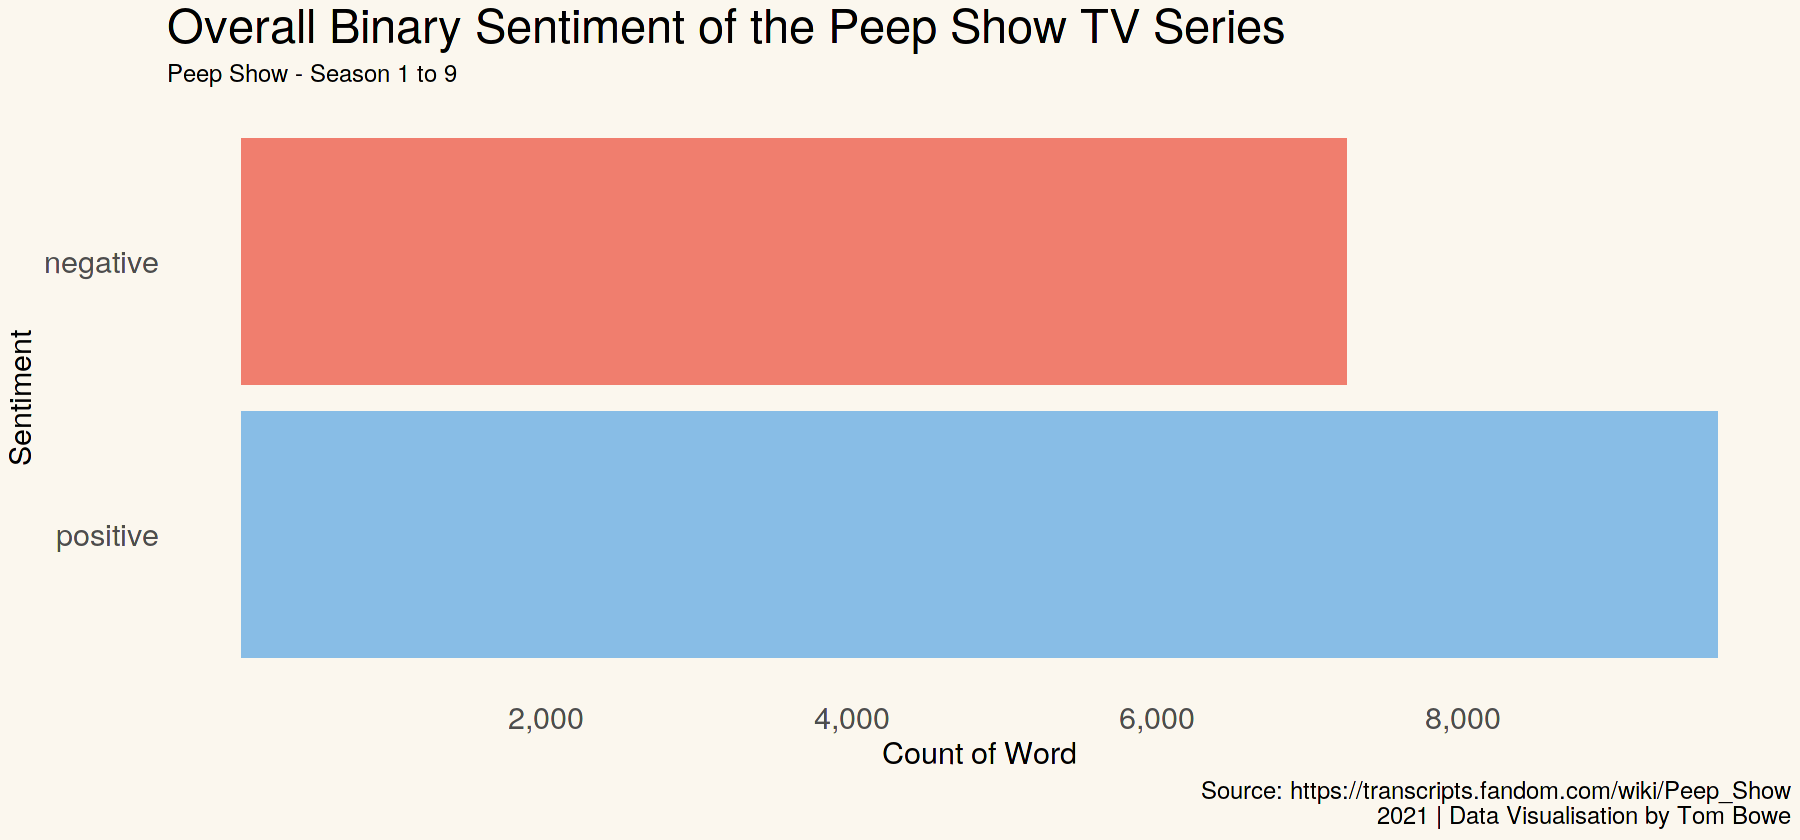

In [49]:
# Arrange the data:
psbingsummary <-
  count(psbing, sentiment, sort = TRUE)

# Visualise:
fig_height(7)
ggplot(psbingsummary, aes(
  x = reorder(sentiment,-n),
  y = n,
  fill = sentiment
)) +
  scale_y_continuous(labels = comma,
                     breaks = seq(from = 2000, to = 8000, by = 2000)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  coord_flip() +
  theme(legend.position = "none") +
  theme_tb() +
  labs(
    y = "Count of Word",
    x = "Sentiment",
    title = "Overall Binary Sentiment of the Peep Show TV Series",
    subtitle = "Peep Show - Season 1 to 9",
    caption = capt
  )

### Overall top contributing unigram sentiments

I apply the Afinn Lexicon to compute a weighted score and see which words are contributing to the overall sentiment of Peep Show.

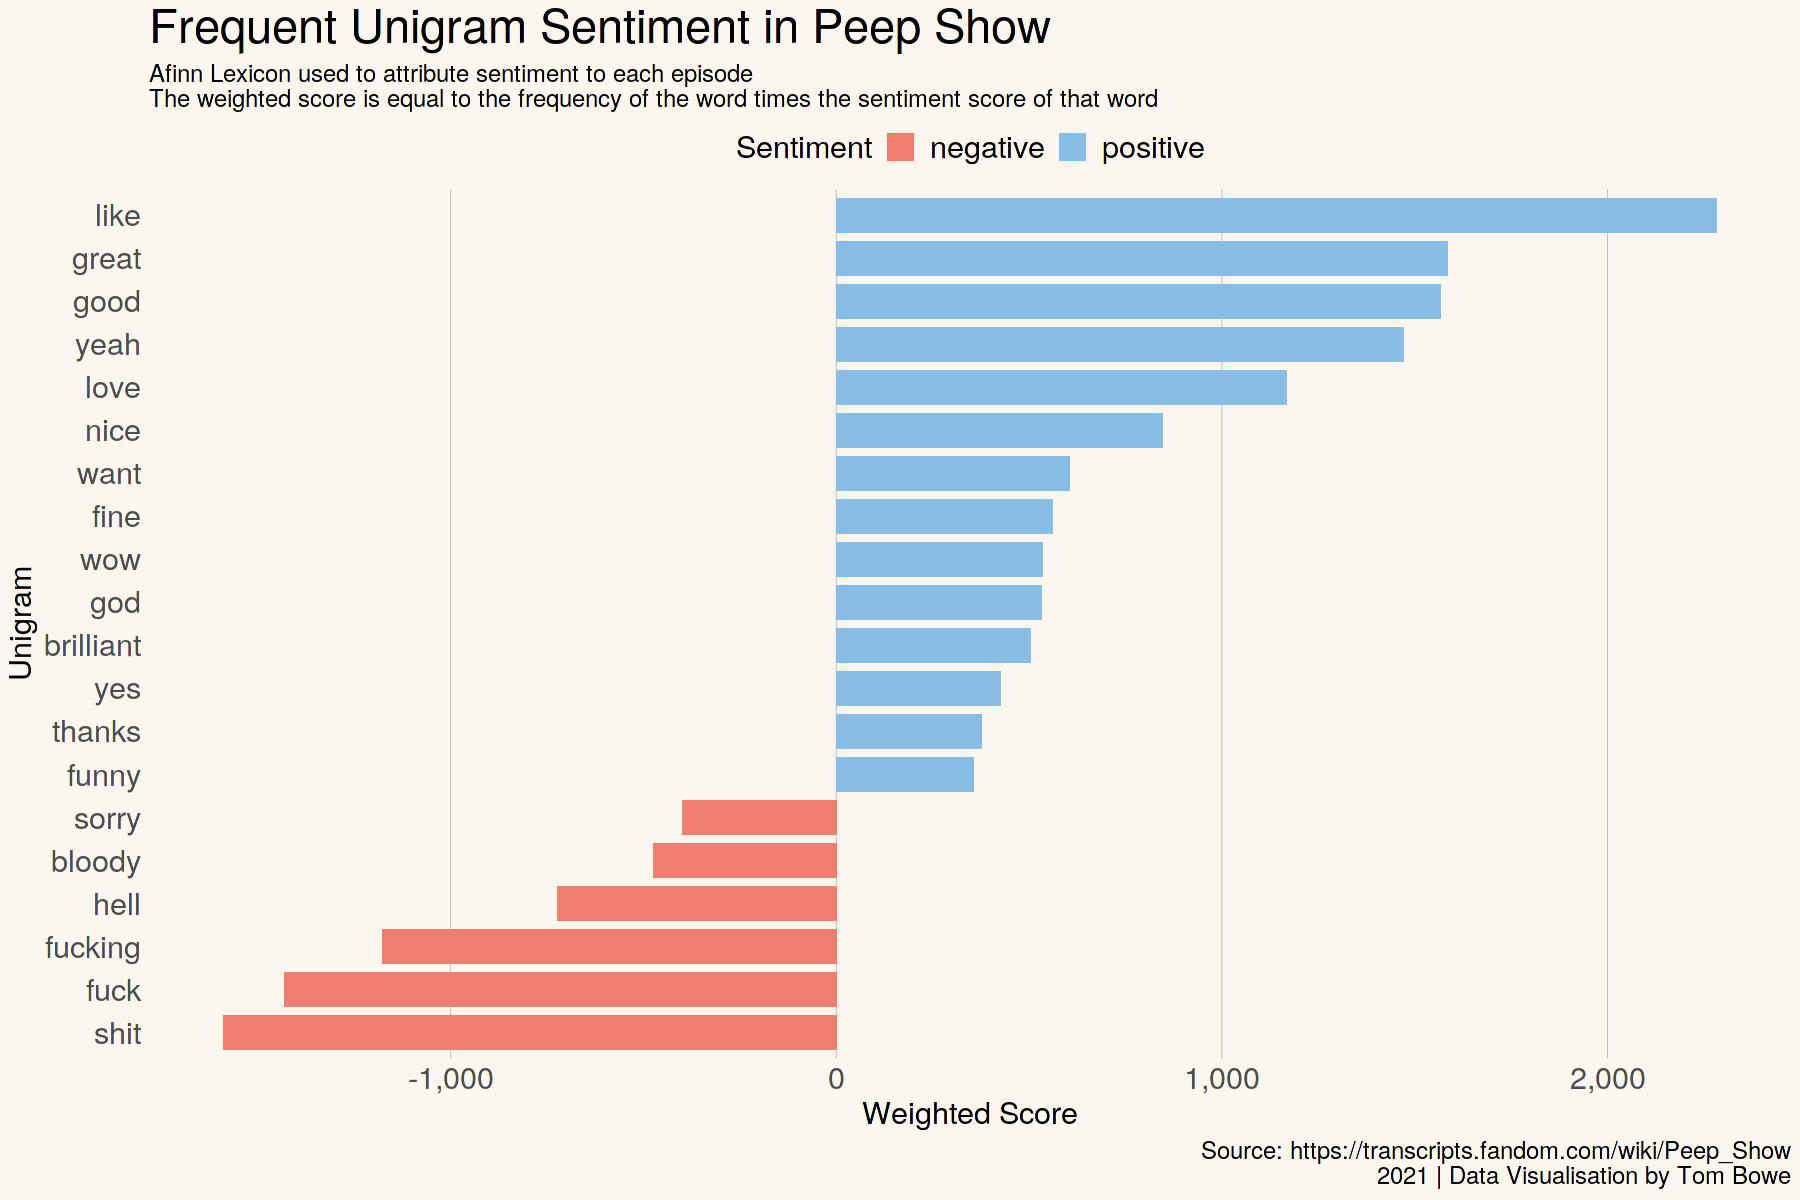

In [51]:
# Arrange the data:
psafinn_all <-
  count(psafinn, word, value) %>%
  mutate(weight = n * value) %>%
  arrange(desc(abs(weight))) %>%
  mutate(sentiment = ifelse(weight < 0, "negative", "positive")) %>%
  slice(1:20)

# Visualise:
fig_height(10)
ggplot(psafinn_all, aes(
  x = reorder(word, weight),
  y = weight,
  fill = sentiment
)) +
  geom_bar(stat = "identity",
           width = 0.8) +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  theme(
    legend.title = element_text(size = 18),
    legend.position = "top",
    legend.direction = "horizontal",
    legend.text = element_text(size = 18),
    legend.background = element_blank()
  ) +
  theme_tb() +
  theme_tb_vert() +
  scale_y_continuous(labels = comma) +
  coord_flip() +
  labs(
    y = "Weighted Score",
    x = "Unigram",
    title = "Frequent Unigram Sentiment in Peep Show",
    subtitle = "Afinn Lexicon used to attribute sentiment to each episode\nThe weighted score is equal to the frequency of the word times the sentiment score of that word",
    caption = capt
  )

### Overall Sentiment Trend
I use the Afinn Lexicon here and assign each word a rated valence score from -5 to 5 depending on how negative or positive it was respectively. I then sum all these scores for each episode to get an overall sentiment score which I can plot.

The positive sentiment observed above manifests in the trend with a few episodes of note that are negative. Season 7 Episode 4 "Nether Zone" where Mark and Jez are locked in a stairwell is by far the most negative of all episodes.

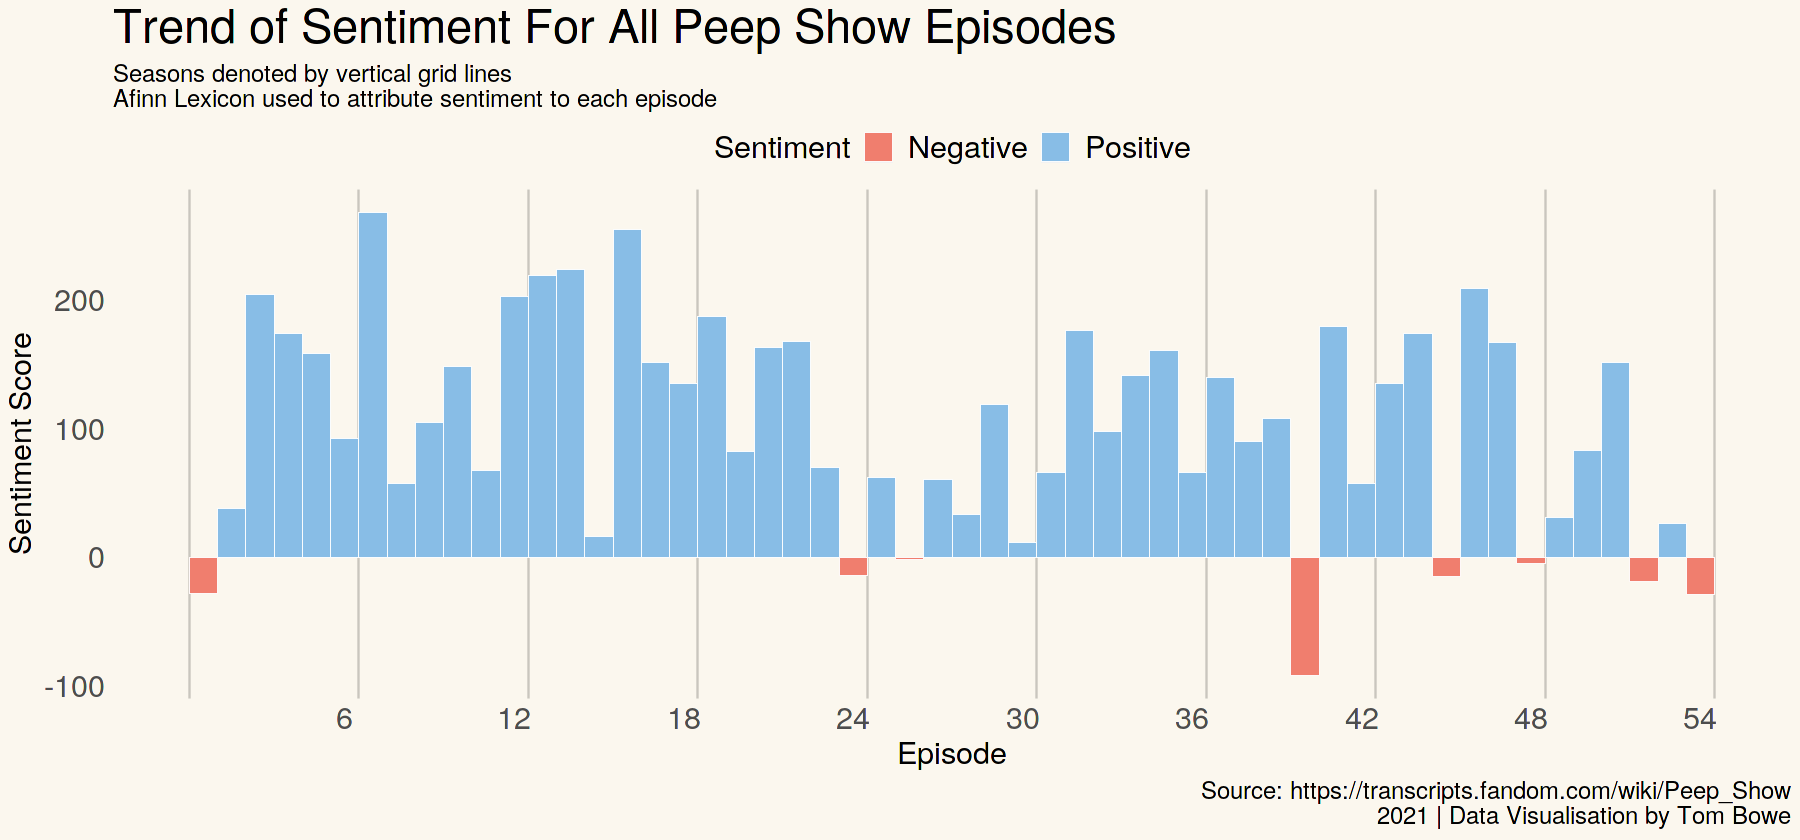

In [53]:
# Arrange the data:
psafinntrend <-
  group_by(psafinn, episode_index) %>%
  summarise(weight = sum(value), .groups = 'drop') %>%
  mutate(sentiment = ifelse(weight < 0, "Negative", "Positive")) %>%
  ungroup()

# Visualise:
fig_height(7)
ggplot(psafinntrend, aes(x = episode_index, y = weight, fill = sentiment)) +
  geom_vline(xintercept = seq(.5, 54.5, 6),
             col = 1,
             alpha = .2) +
  geom_bar(
    stat = "identity",
    colour = "white",
    size = 0.2,
    width = 1
  ) +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  scale_x_continuous(breaks = seq(from = 6, to = 54, by = 6)) +
  theme(
    legend.position = "top",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 18),
    legend.background = element_blank()
  ) +
  theme_tb() +
  labs(
    y = "Sentiment Score",
    x = "Episode",
    title = "Trend of Sentiment For All Peep Show Episodes",
    subtitle = "Seasons denoted by vertical grid lines\nAfinn Lexicon used to attribute sentiment to each episode",
    caption = capt
  )

### Sentiment Trend for Mark and Jeremy
I use the Afinn Lexicon here again but this time I subset only for Mark or Jeremy dialogue/monologue and plot using a heatmap.

We can see "Nether Zone" is apparent here with negative sentiments from both Mark and Jez, but interestingly episode 4, season 5 Mark is overall positive while Jeremy is extremely negative. Why is this? This episode is "Jeremy's Mummy" in which Jez isn't too happy about his mother's new partner and makes it quite apparent. On the flip side of this, Mark actually quite likes the new partner, holding him in high regard and tries to impress him throughout.

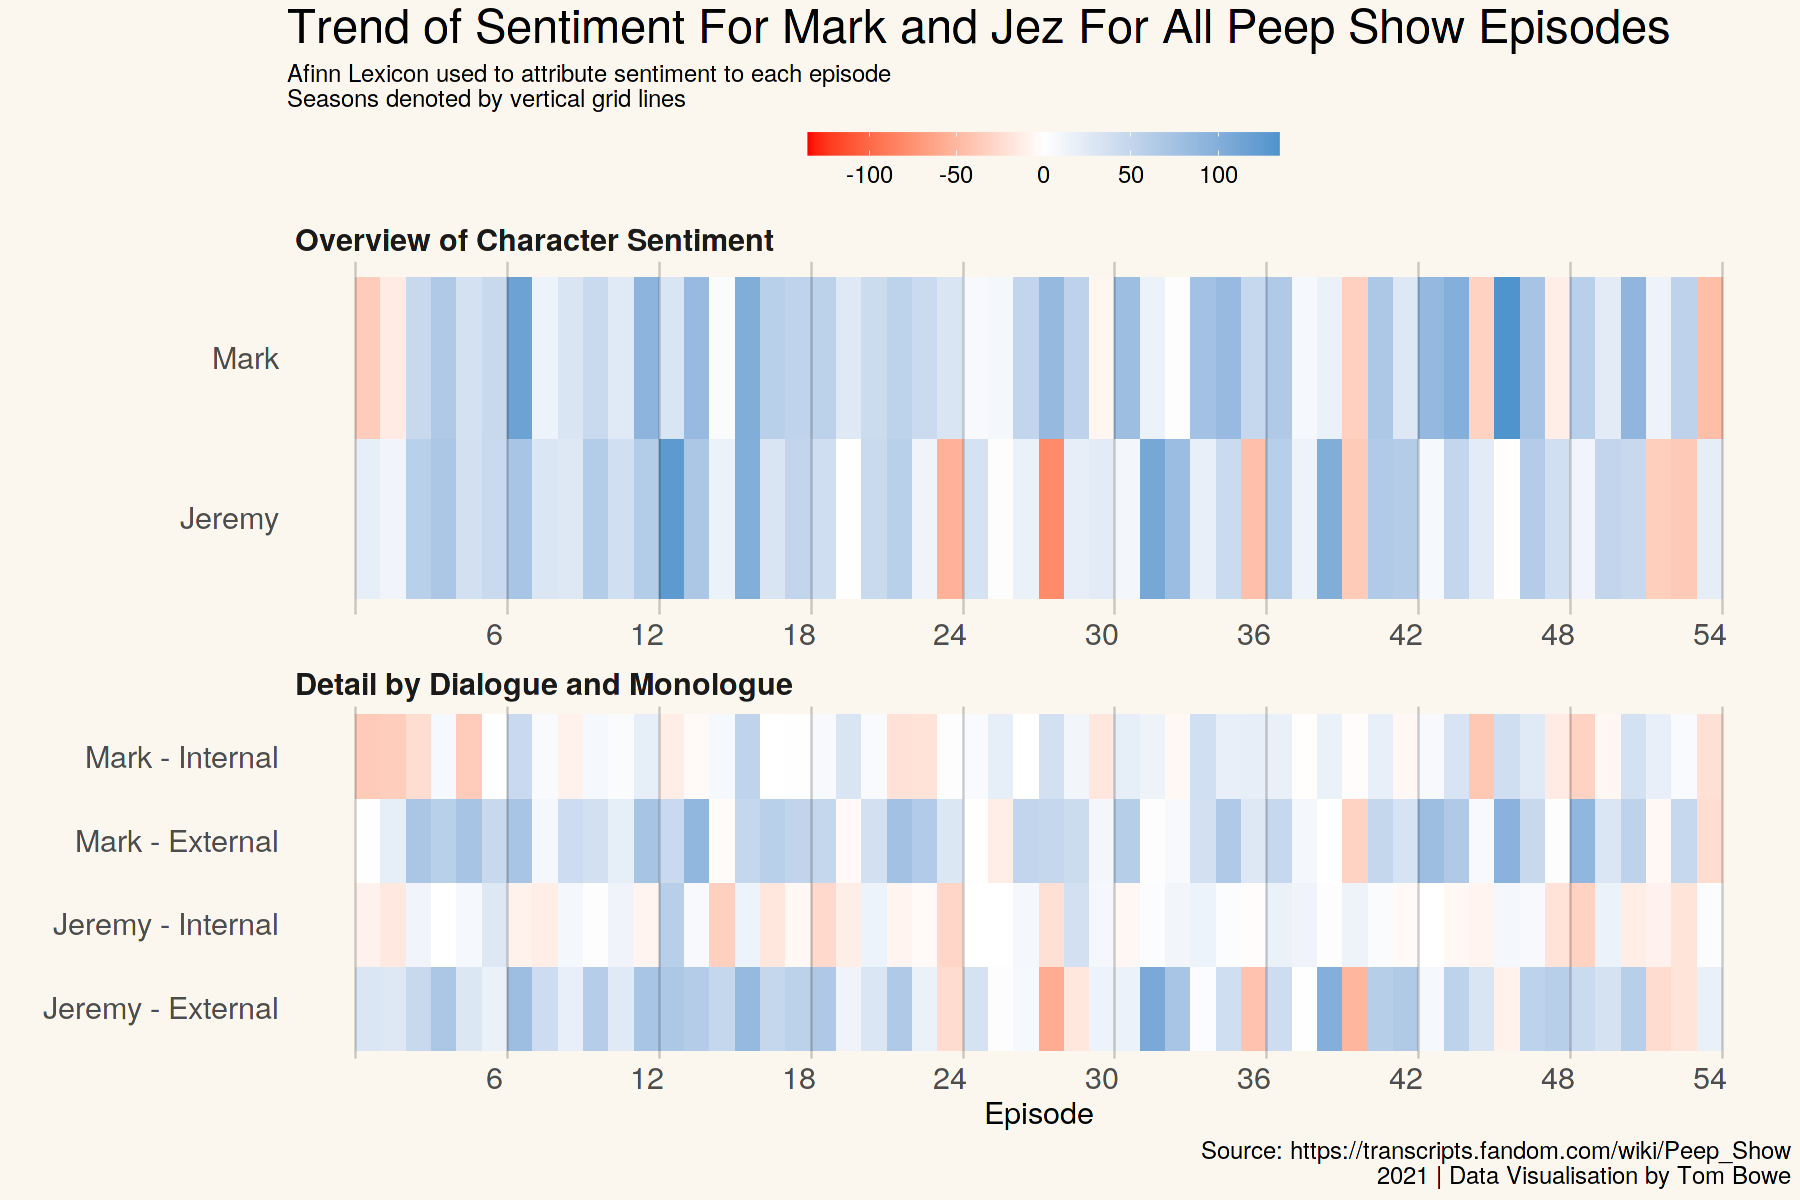

In [58]:
# Arrange the data:
hm <-
  group_by(psafinn, character, episode_index) %>%
  summarise(weight = sum(value),
            n = n(),
            .groups = 'drop') %>%
  subset(character %in% c("Mark", "Jeremy")) %>%
  mutate(category = character, dialogue_type = "All")

hm_detail <-
  group_by(psafinn, character, dialogue_type, episode_index) %>%
  summarise(weight = sum(value),
            n = n(),
            .groups = 'drop') %>%
  subset(character %in% c("Mark", "Jeremy")) %>%
  mutate(category = paste(character, dialogue_type, sep = " - "))

hm_overall <-
  rbind(hm, hm_detail) %>%
  mutate(
    facet_category = case_when(
      str_detect(category, " - ") == TRUE ~ "Detail by Dialogue and Monologue",
      TRUE ~ "Overview of Character Sentiment"
    )
  ) %>%
  transform(category =
              factor(
                category,
                levels =
                  c(
                    "Jeremy - External",
                    "Jeremy - Internal",
                    "Mark - External",
                    "Mark - Internal",
                    "Jeremy",
                    "Mark"
                  )
              )) %>%
  transform(facet_category =
              factor(
                facet_category,
                levels =
                  c(
                    "Overview of Character Sentiment",
                    "Detail by Dialogue and Monologue"
                  )
              ))

# Visualise
fig_height(10)
ggplot(data = hm_overall, aes(y = category, x = episode_index, fill = weight)) +
  geom_tile() +
  scale_fill_gradient2(
    midpoint = 0,
    low = "red",
    mid = "white",
    high = "steelblue3",
    name = "Sentiment",
    limits = c(-135, 135)
  ) +
  scale_x_continuous(breaks = seq(from = 6, to = 54, by = 6)) +
  facet_wrap( ~ facet_category, nrow = 2, scales = "free") +
  geom_vline(xintercept = seq(.5, 54.5, 6),
             col = 1,
             alpha = .2) +
  theme_tb() +
  theme(
    legend.position = "top",
    legend.direction = "horizontal",
    legend.key.size = unit(0.5, "cm"),
    legend.key.width = unit(2, "cm"),
    legend.title = element_blank(),
    legend.text = element_text(size = 14),
    legend.background = element_blank()
  ) +
  labs(
    y = "",
    x = "Episode",
    title = "Trend of Sentiment For Mark and Jez For All Peep Show Episodes",
    subtitle = "Afinn Lexicon used to attribute sentiment to each episode\nSeasons denoted by vertical grid lines",
    caption = capt
  )

### What Made "Nether Zone" so Negative?
In this episode, both Mark and Jez get locked in Zahra's apartment lobby on the day of Mark's son's christening. I drill down to the most frequent words used in the episode by Jeremy and Mark and create a weighted score based on how often they were used multiplied by the sentiment valence score per the Afinn Lexicon, I then plot accordingly.

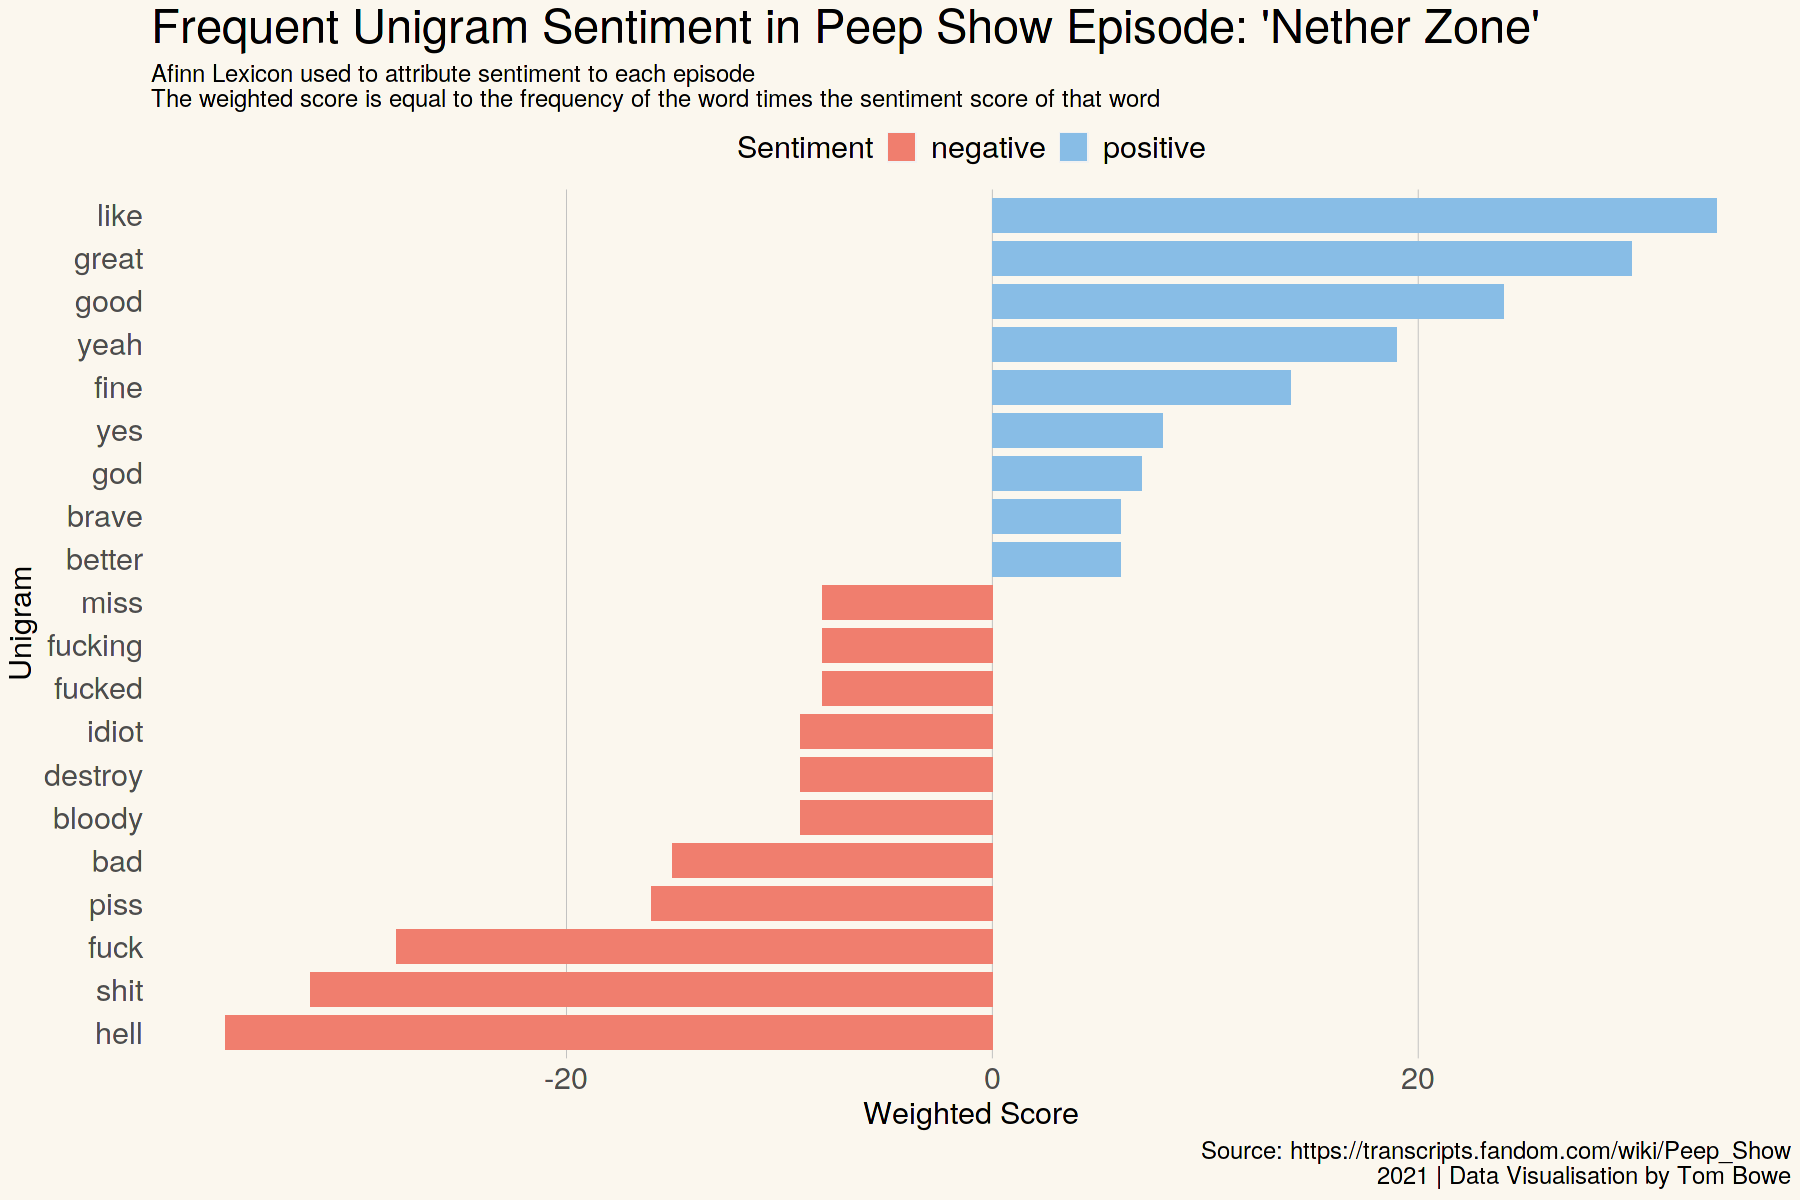

In [60]:
# Arrange the data:
pss07e04 <-
  subset(psafinn,
         episode_number == "Episode 4" & season_number == "Season 7") %>%
  count(word, value) %>%
  mutate(weight = n * value) %>%
  arrange(desc(abs(weight))) %>%
  mutate(sentiment = ifelse(weight < 0, "negative", "positive")) %>%
  slice(1:20)

# Visualise:
fig_height(10)
ggplot(pss07e04, aes(
  x = reorder(word, weight),
  y = weight,
  fill = sentiment
)) +
  geom_bar(stat = "identity",
           width = 0.8) +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  theme(
    legend.title = element_text(size = 18),
    legend.position = "top",
    legend.direction = "horizontal",
    legend.text = element_text(size = 18),
    legend.background = element_blank()
  ) +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(
    y = "Weighted Score",
    x = "Unigram",
    title = "Frequent Unigram Sentiment in Peep Show Episode: 'Nether Zone'",
    subtitle = "Afinn Lexicon used to attribute sentiment to each episode\nThe weighted score is equal to the frequency of the word times the sentiment score of that word",
    caption = capt
  )

### What Made Jeremy in the Episode "Jeremy's Mummy" so Negative?
In this episode, Jez isn't too happy about his mother's new partner and makes it quite apparent. How Apparent? Let's take a look. I use the same weighted score approach as above.

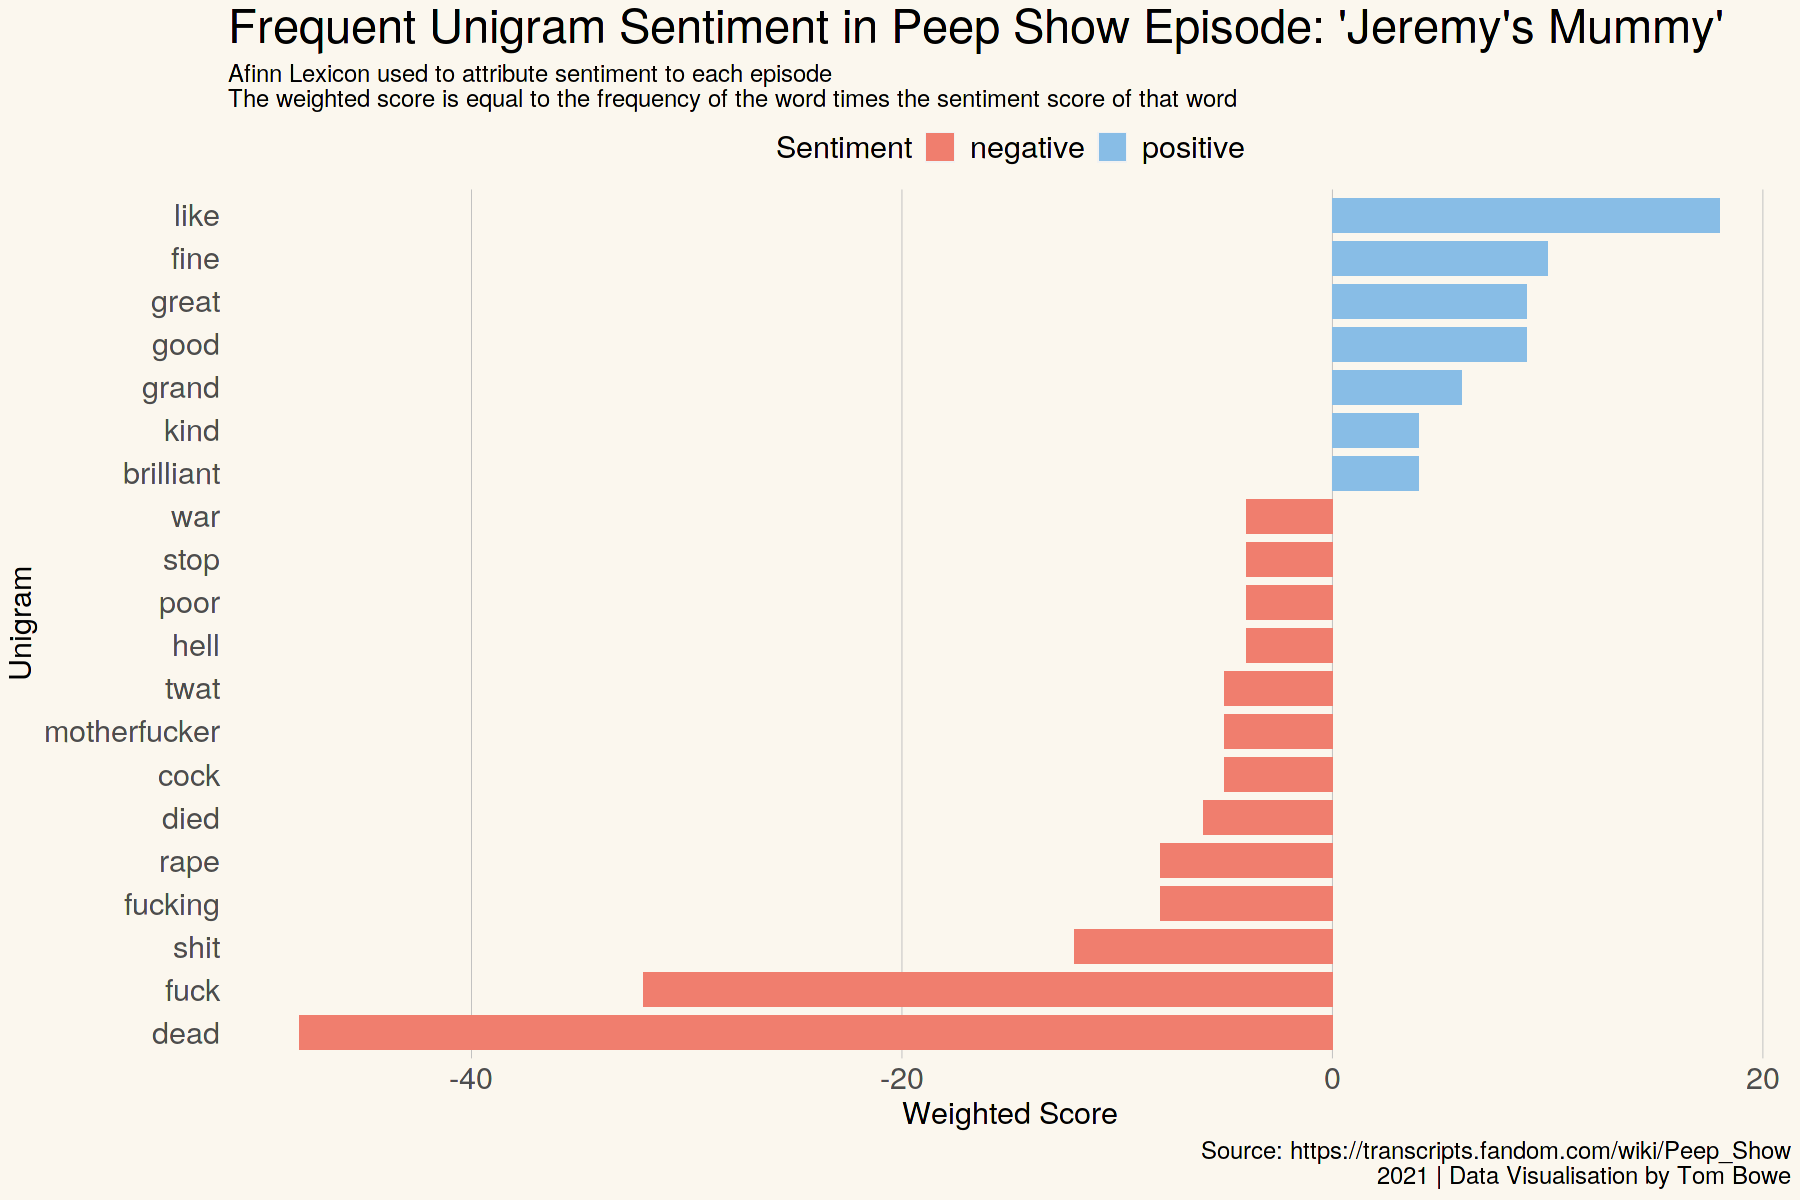

In [61]:
# Arrange the data:
pss05e04 <-
  subset(
    psafinn,
    episode_number == "Episode 4" &
      season_number == "Season 5" & character == "Jeremy"
  ) %>%
  count(word, value) %>%
  mutate(weight = n * value) %>%
  arrange(desc(abs(weight))) %>%
  mutate(sentiment = ifelse(weight < 0, "negative", "positive")) %>%
  slice(1:20)

# Visualise:
fig_height(10)
ggplot(pss05e04, aes(
  x = reorder(word, weight),
  y = weight,
  fill = sentiment
)) +
  geom_bar(stat = "identity",
           width = .8) +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  theme(
    legend.position = "top",
    legend.direction = "horizontal",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 18),
    legend.background = element_blank()
  ) +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(
    y = "Weighted Score",
    x = "Unigram",
    title = "Frequent Unigram Sentiment in Peep Show Episode: 'Jeremy's Mummy'",
    subtitle = "Afinn Lexicon used to attribute sentiment to each episode\nThe weighted score is equal to the frequency of the word times the sentiment score of that word",
    caption = capt
  )

### Funnel Plot to Detect Character Sentiment Outliers
What I often see in transcript sentiment analysis is the character will be rated as more negative or more positive on a simple scale using some form of lexicon, but no thought is given to how many words that character uttered during the show. If I were to roll two die, its more likely I am going to roll two sixes than it would be to roll ten sixes on ten die. I.e. the odds of getting a rate of occurance that deviates far from the mean is far more likely in small sample sizes.

Chance would *not* be a fine thing in this case.

I therefore employ the funnel plot to cut through this effect. Note that there are 2 characters (They are not labelled but for reference they are Ben 55% and Andy 56%) that are clearly the most negative characters in the show. However, they barely said any words compared to other characters. Note that Super Hans said 761 words*, a far larger sample size to draw from, his unusually negative sentiment when compared to the average is more likely to be genuine and not due to random variation and therefore is an interesting insight. We know this because the point sits beyond the 99.9% confidence interval meaning there is a <0.1% chance that his unusually high sentiment rate (compared to the mean) was due to random variation.

On the flip side, we note Sophie is sitting just beyond the lower 99.9% confidence interval meaning her unusually positive sentiment is also significant, more so than Zahra (28%) who spoke only 61 words*.

I've applied this technique successfully to a few shows and movies to date:

* [Lord of the Rings Movie Trilogy](https://www.kaggle.com/tombowe/lord-of-the-rings-sentiment-outliers)
* [Star Wars Original Movie Trilogy](https://www.kaggle.com/tombowe/star-wars-character-sentiment-outlier-detection)
* [Stargate SG1 TV Series](https://www.kaggle.com/tombowe/stargate-sg1-dialogue-text-analysis)

**Please note that this count of words are just the words to which I could assign sentiment and do not include neutral words or stop words.*

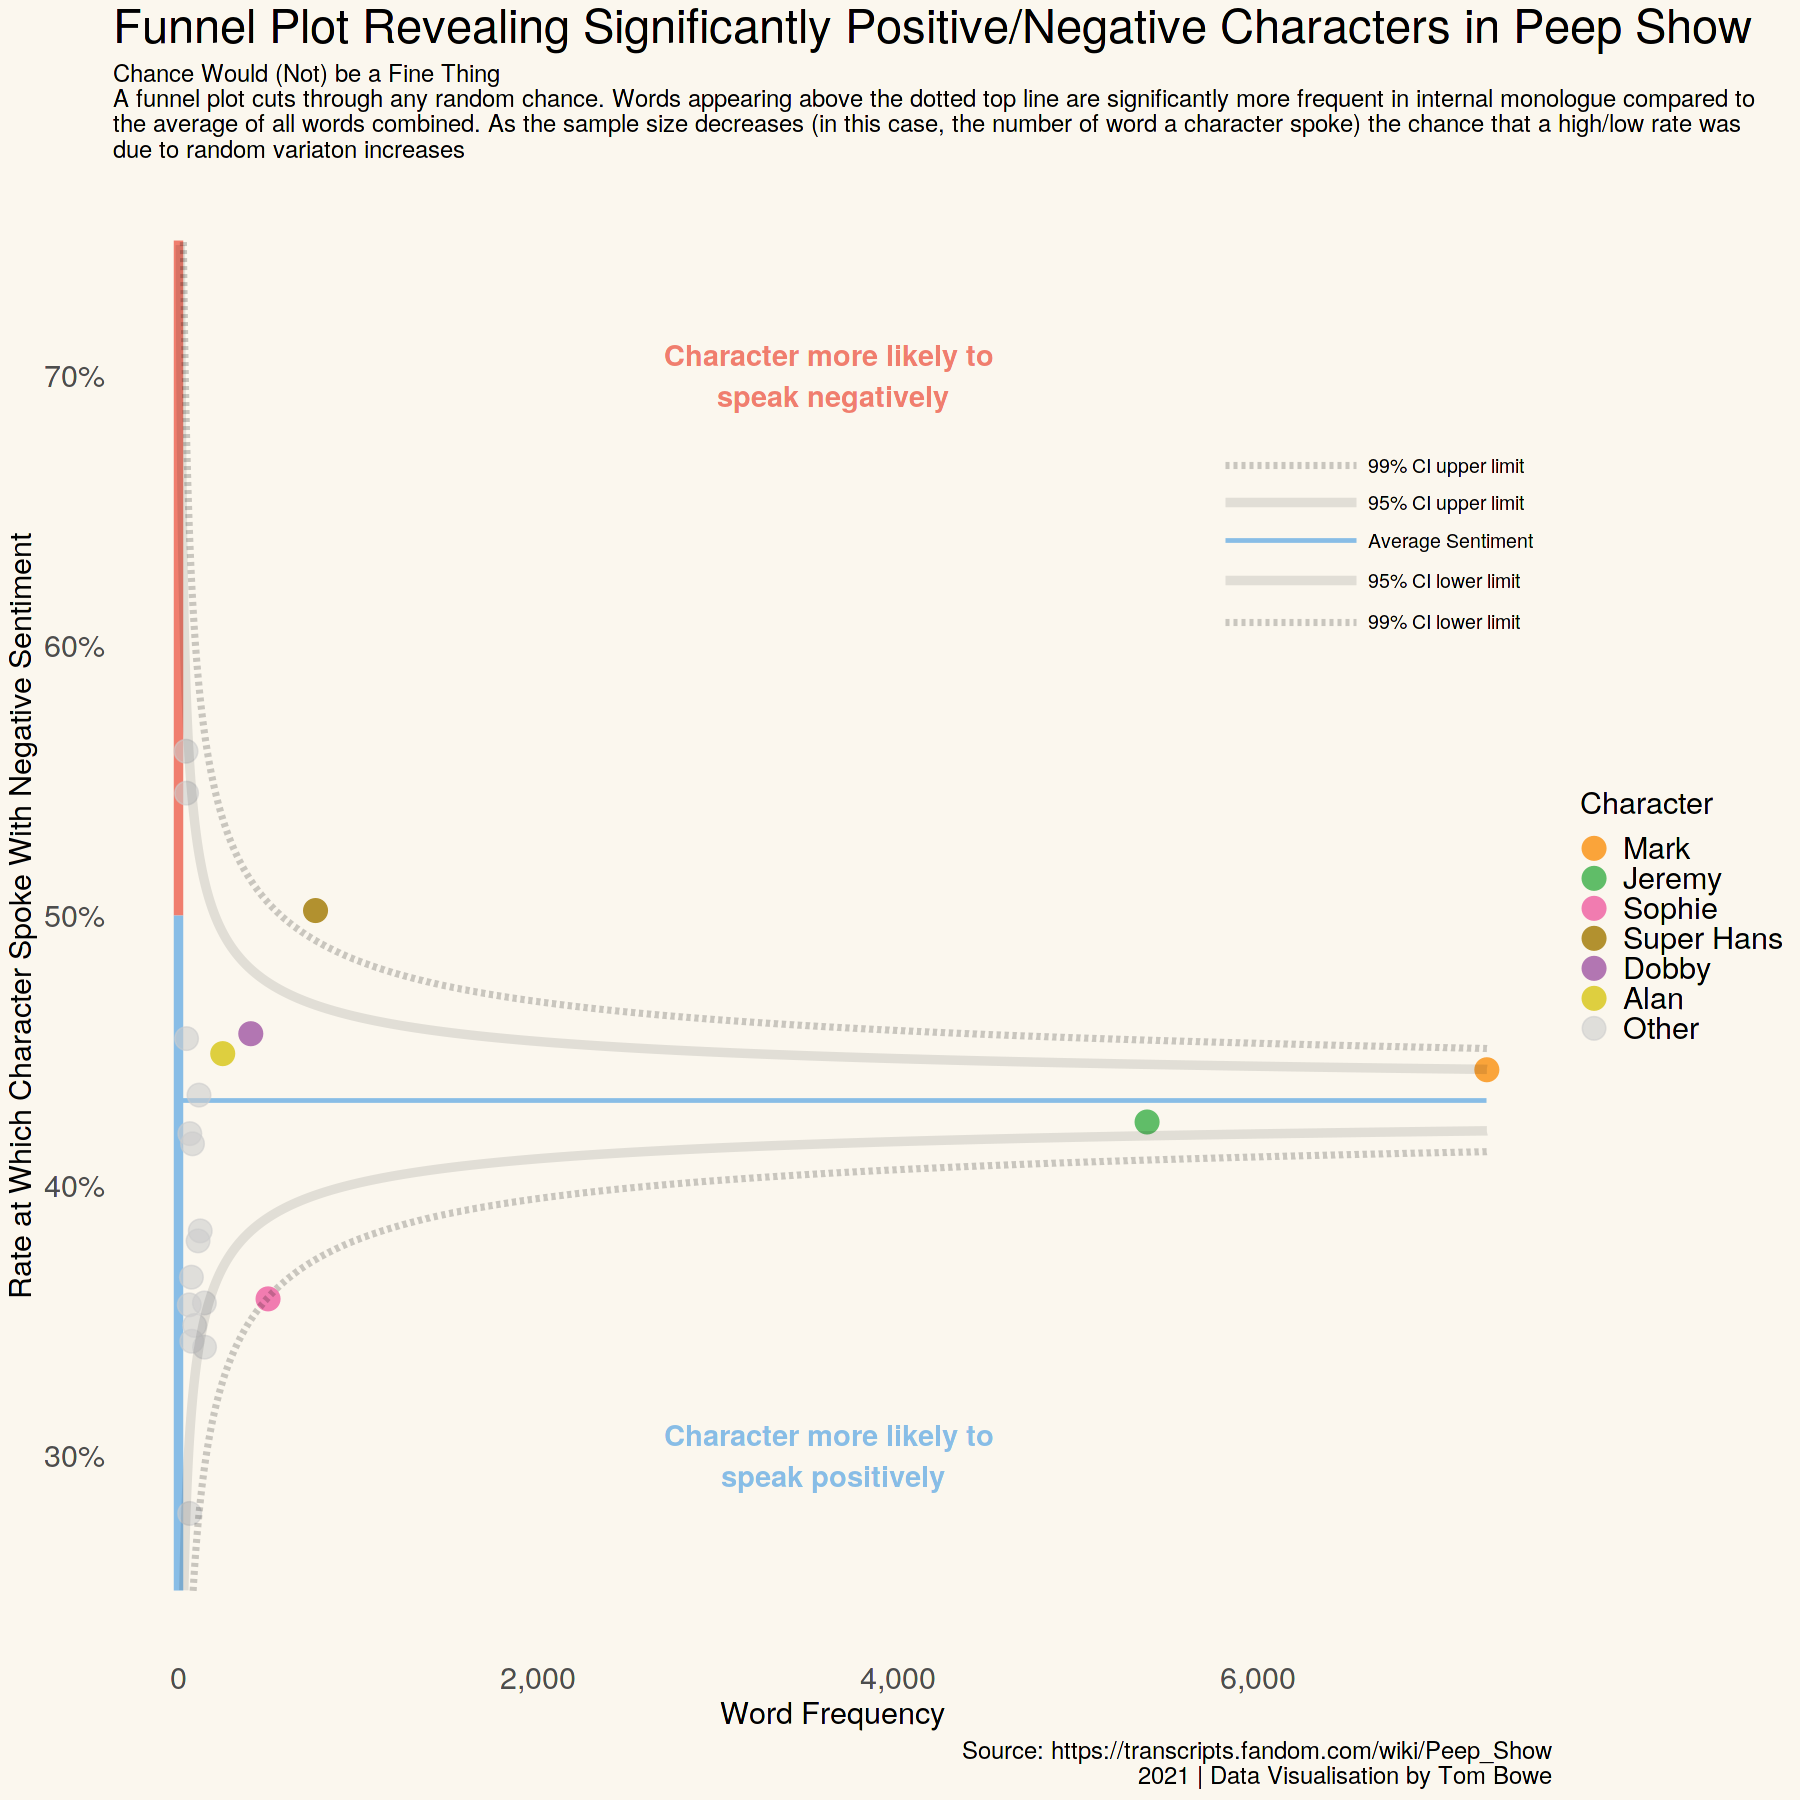

In [62]:
# Arrange the data:
# Calculate total number
bingtotal <-
  count(psbing, character) %>%
  rename(number = n)

popchar <-
  count(psbing, character, sentiment) %>%
  subset(sentiment == "negative") %>%
  select(character, n) %>%
  rename(negative = n) %>%
  inner_join(bingtotal, "character") %>%
  mutate(p = negative / number) %>%
  mutate(p.se = sqrt((p * (1 - p)) / (number))) %>%
  select(character, p, number, p.se) %>%
  subset(p.se > 0) %>%
  mutate(p.fem = weighted.mean(p, 1 / p.se ^ 2)) %>%
  mutate(character = as.character(character)) %>%
  subset(number > 40) %>%
  mutate(char_col = case_when((
    character %in% c("Mark", "Jeremy", "Sophie", "Super Hans", "Dobby", "Alan")
  ) == TRUE ~ character,
  TRUE ~ "Other")) %>%
  transform(char_col = factor(
    char_col,
    levels = c(
      "Mark",
      "Jeremy",
      "Sophie",
      "Super Hans",
      "Dobby",
      "Alan",
      "Other"
    )
  ))

# Set boundaries of the chart
boundx <- max(popchar$number)

# Create dataframes to draw legend
u99leg <-
  data.frame(
    x1 = (boundx / 5) * 4,
    x2 = (boundx / 5) * 4.5,
    y1 = 1,
    y2 = 1
  )
u95leg <-
  data.frame(
    x1 = (boundx / 5) * 4,
    x2 = (boundx / 5) * 4.5,
    y1 = 0.96,
    y2 = 0.96
  )
wmeanleg <-
  data.frame(
    x1 = (boundx / 5) * 4,
    x2 = (boundx / 5) * 4.5,
    y1 = 0.92,
    y2 = 0.92
  )
l95leg <-
  data.frame(
    x1 = (boundx / 5) * 4,
    x2 = (boundx / 5) * 4.5,
    y1 = 0.88,
    y2 = 0.88
  )
l99leg <-
  data.frame(
    x1 = (boundx / 5) * 4,
    x2 = (boundx / 5) * 4.5,
    y1 = 0.84,
    y2 = 0.84
  )

# Common effect (fixed effect model)
p.fem <- weighted.mean(popchar$p, 1 / popchar$p.se ^ 2)

# Create a dataframe in order to draw the weighted mean line
dfwm <- data.frame(x1 = 0,
                   x2 = boundx,
                   y1 = p.fem,
                   y2 = p.fem)

# Lower and upper limits for 95% and 99.9% CI, based on FEM estimator
number.seq <- seq(0, boundx, 0.1)
number.ll95 <-
  p.fem - 1.96 * sqrt((p.fem * (1 - p.fem)) / (number.seq))
number.ul95 <-
  p.fem + 1.96 * sqrt((p.fem * (1 - p.fem)) / (number.seq))
number.ll999 <-
  p.fem - 3.29 * sqrt((p.fem * (1 - p.fem)) / (number.seq))
number.ul999 <-
  p.fem + 3.29 * sqrt((p.fem * (1 - p.fem)) / (number.seq))
dfCI <-
  data.frame(number.ll95,
             number.ul95,
             number.ll999,
             number.ul999,
             number.seq,
             p.fem)

#### Draw funnel plot
fig_height(15)

# Select characters of note to label
#label <- subset(popchar, character %in% c())

othercol <-
  rgb(204,
      204,
      204,
      max = 255,
      alpha = 150,
      names = "othercol")

# Create a dynamic weighted mean line colour dependent on if the sentiment is positive, negative, or neutral
meancol <- case_when(
  (p.fem > 0.5) == TRUE ~ "#F07E6E",
  # Red
  (p.fem < 0.5) == TRUE ~ "#88BDE6",
  # Blue
  (p.fem == 0) == TRUE ~ "dark gray",
  TRUE ~ "dark gray"
)

ggplot(popchar, aes(x = number, y = p)) +
  
  # Draw the weighted mean line as a segment
  geom_segment(
    aes(
      x = x1,
      y = y1,
      xend = x2,
      yend = y2,
      label = NULL
    ),
    data = dfwm,
    colour = meancol,
    size = 1
  ) +
  
  # Draw the dialogue line
  geom_segment(
    aes(
      x = 0,
      y = 0.5,
      xend = 0,
      yend = .75,
      label = NULL
    ),
    data = l99leg,
    colour = "#F07E6E",
    size = 2
  ) + ggplot2::annotate(
    "text",
    x = boundx / 2,
    y = .7,
    hjust = 0.5,
    fontface = 2,
    colour = "#F07E6E",
    label = "Character more likely to \nspeak negatively",
    size = 6
  ) +
  
  # Draw the internal monologue line
  geom_segment(
    aes(
      x = 0,
      y = 0.25,
      xend = 0,
      yend = 0.5,
      label = NULL
    ),
    data = l99leg,
    colour = "#88BDE6",
    size = 2
  ) + ggplot2::annotate(
    "text",
    x = boundx / 2,
    y = .3,
    hjust = 0.5,
    fontface = 2,
    colour = "#88BDE6",
    label = "Character more likely to \nspeak positively",
    size = 6
  ) +
  
  # Draw the character points and assign aesthetics
  geom_point(aes(colour = char_col), size = 6) +
  #scale_shape_manual(values = c(Female = 18, Male = 20), name = "Gender") +
  scale_colour_manual(
    values = c(
      "#FAA43A",
      "#60BD68",
      "#F17CB0",
      "#B2912F",
      "#B276B2",
      "#DECF3F",
      othercol
    ),
    name = "Character"
  ) +
  
  # Draw the confidence interval lines
  geom_line(
    aes(x = number.seq, y = number.ll95, label = NULL),
    colour = 1,
    alpha = 0.1,
    size = 2,
    data = dfCI
  ) +
  geom_line(
    aes(x = number.seq, y = number.ul95, label = NULL),
    colour = 1,
    alpha = 0.1,
    size = 2,
    data = dfCI
  ) +
  geom_line(
    aes(x = number.seq, y = number.ll999, label = NULL),
    linetype = "dashed",
    size = 1.5,
    colour = 1,
    alpha = 0.2,
    data = dfCI
  ) +
  geom_line(
    aes(x = number.seq, y = number.ul999, label = NULL),
    linetype = "dashed",
    size = 1.5,
    colour = 1,
    alpha = 0.2,
    data = dfCI
  ) +
  
  # Customise axis
  scale_y_continuous(limits = c(0.25, .75), labels = percent_format(accuracy = 1L)) +
  scale_x_continuous(labels = comma) +
  
  # Create theme
  theme(
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 18),
    legend.background = element_blank(),
    legend.key = element_blank()
  ) +
  theme_tb() +
  
  # Draw the CI legend
  geom_segment(
    aes(
      x = x1,
      y = y1 / 1.5,
      xend = x2,
      yend = y2 / 1.5,
      label = NULL
    ),
    data = u99leg,
    colour = 1,
    size = 1.5,
    linetype = "dashed",
    alpha = 0.2
  ) + ggplot2::annotate(
    "text",
    x = u99leg$x2 * 1.01,
    y = u99leg$y2 / 1.5,
    hjust = 0,
    label = "99% CI upper limit",
    size = 4
  ) +
  geom_segment(
    aes(
      x = x1,
      y = y1 / 1.47,
      xend = x2,
      yend = y2 / 1.47,
      label = NULL
    ),
    data = u95leg,
    colour = 1,
    size = 2,
    alpha = 0.1
  ) + ggplot2::annotate(
    "text",
    x = u95leg$x2 * 1.01,
    y = u95leg$y2 / 1.47,
    hjust = 0,
    label = "95% CI upper limit",
    size = 4
  ) +
  geom_segment(
    aes(
      x = x1,
      y = y1 / 1.44,
      xend = x2,
      yend = y2 / 1.44,
      label = NULL
    ),
    data = wmeanleg,
    colour = meancol,
    size = 1
  ) + ggplot2::annotate(
    "text",
    x = wmeanleg$x2 * 1.01,
    y = wmeanleg$y2 / 1.44,
    hjust = 0,
    label = "Average Sentiment",
    size = 4
  ) +
  geom_segment(
    aes(
      x = x1,
      y = y1 / 1.41,
      xend = x2,
      yend = y2 / 1.41,
      label = NULL
    ),
    data = l95leg,
    colour = 1,
    size = 2,
    alpha = 0.1
  ) + ggplot2::annotate(
    "text",
    x = l95leg$x2 * 1.01,
    y = l95leg$y2 / 1.41,
    hjust = 0,
    label = "95% CI lower limit",
    size = 4
  ) +
  geom_segment(
    aes(
      x = x1,
      y = y1 / 1.38,
      xend = x2,
      yend = y2 / 1.38,
      label = NULL
    ),
    data = l99leg,
    colour = 1,
    size = 1.5,
    linetype = "dashed",
    alpha = 0.2
  ) + ggplot2::annotate(
    "text",
    x = l99leg$x2 * 1.01,
    y = l99leg$y2 / 1.38,
    hjust = 0,
    label = "99% CI lower limit",
    size = 4
  ) +
  
  # Label the plot appropriately
  labs(
    y = "Rate at Which Character Spoke With Negative Sentiment",
    x = "Word Frequency",
    title = "Funnel Plot Revealing Significantly Positive/Negative Characters in Peep Show",
    subtitle = "Chance Would (Not) be a Fine Thing
A funnel plot cuts through any random chance. Words appearing above the dotted top line are significantly more frequent in internal monologue compared to
the average of all words combined. As the sample size decreases (in this case, the number of word a character spoke) the chance that a high/low rate was
due to random variaton increases",
    caption = capt
  )

### Using the NRC Lexicon to Assess Character Emotion
I now turn my attention to the emotions displayed by the major characters. I am able to take all the major words each character spoke and assign an emotion to them. I then assess what percentage each emotion contributed to their total dialogue and plot accordingly.

I've noted that the overall distribution of emotion is fairly similar across the board in most characters for any Movie or TV Show. What I think is important to observe in analysis of this type are things like: 

* Who is the angriest character? (Super Hans)
* Who is the saddest? (Sophie)

And so on, and so forth. This is why I facet by Emotion, and not by Character.

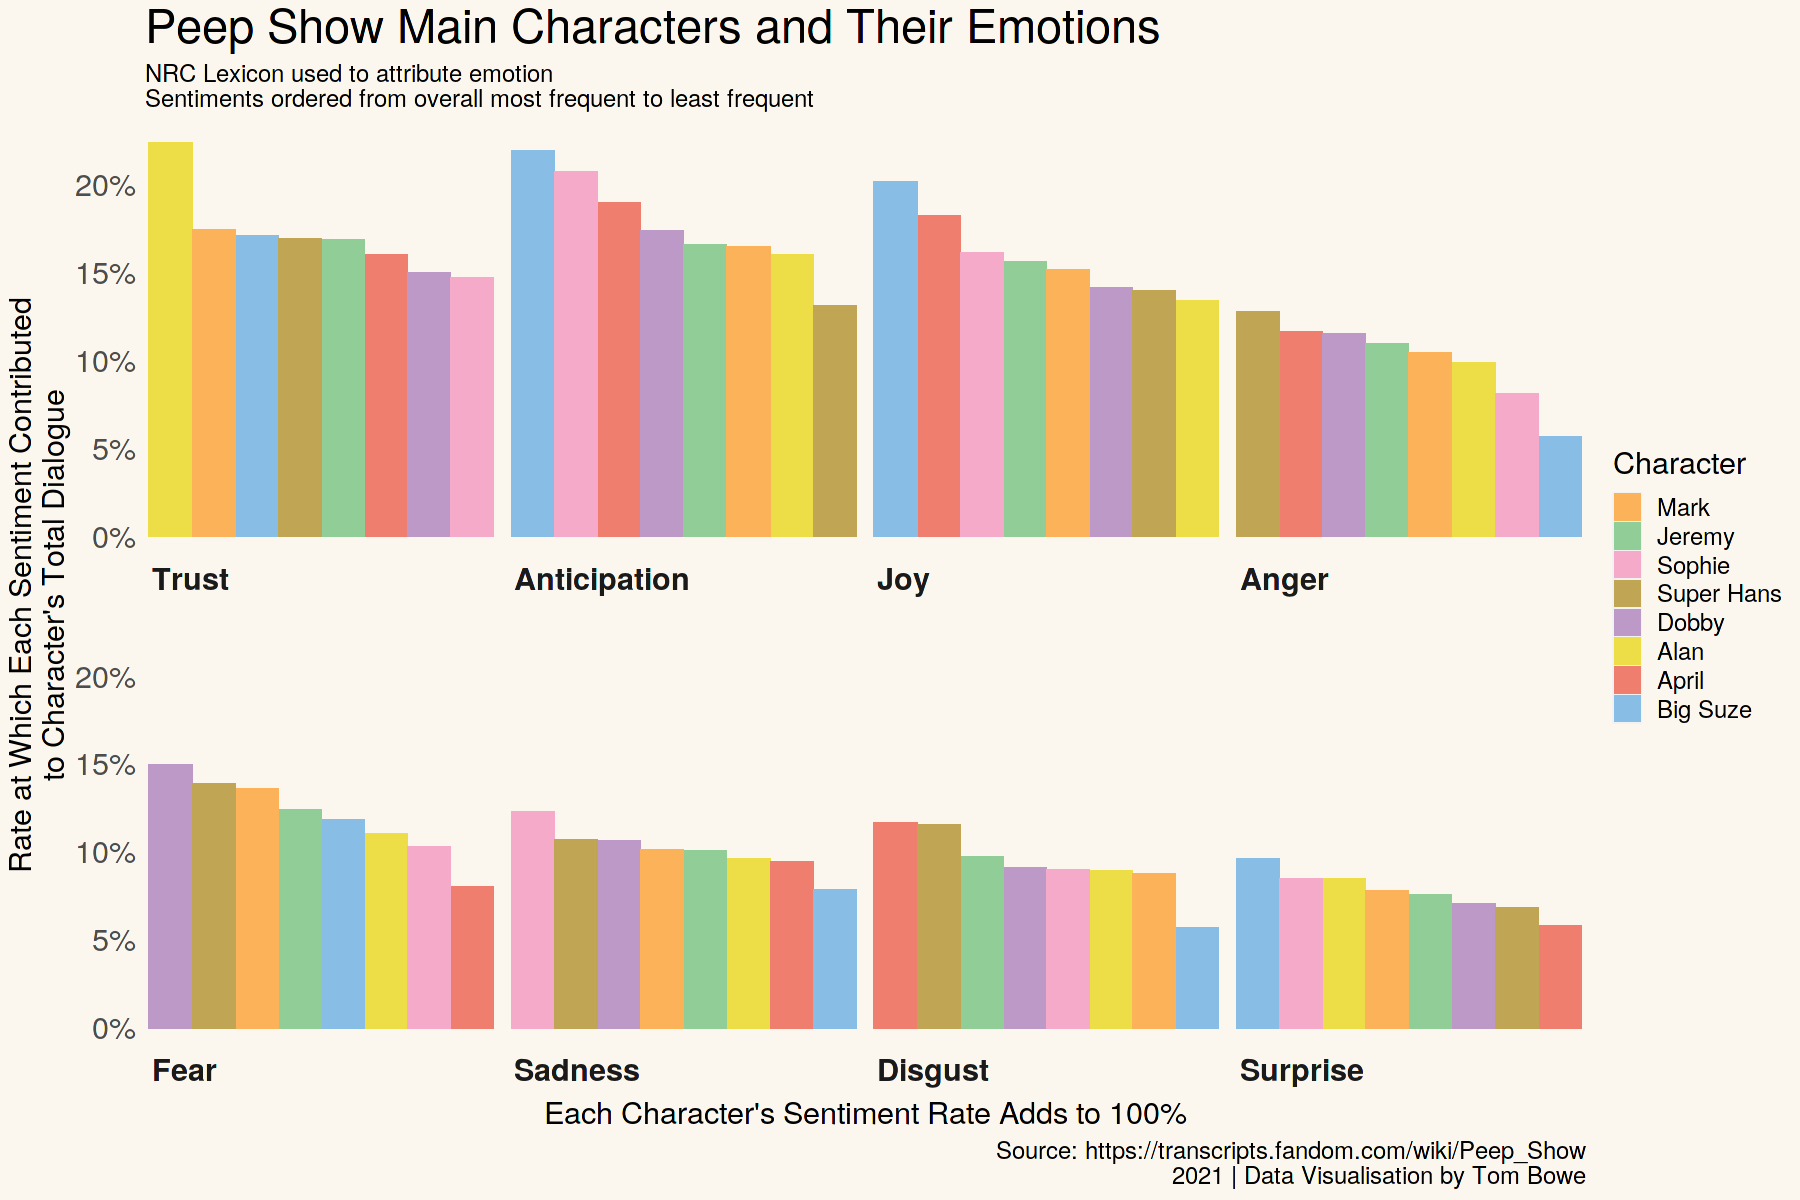

In [66]:
# Arrange the data:
nrcmc <-
  subset(psnrc, (!(sentiment %in% c(
    "positive", "negative"
  )))) %>%
  count(character, sentiment)
psnrctotal <-
  subset(psnrc, (!(sentiment %in% c(
    "positive", "negative"
  )))) %>%
  count(character)
psnrcrel <-
  subset(psnrc, (!(sentiment %in% c(
    "positive", "negative"
  )))) %>%
  count(character, sentiment) %>%
  select(character, sentiment, n) %>%
  inner_join(psnrctotal, "character") %>%
  mutate(p = n.x / n.y) %>%
  subset(
    character %in% c(
      "Mark",
      "Jeremy",
      "Sophie",
      "Super Hans",
      "Dobby",
      "Alan",
      "April",
      "Big Suze"
    )
  ) %>%
  mutate(sentiment = str_replace_all(sentiment, "trust", "Trust")) %>%
  mutate(sentiment = str_replace_all(sentiment, "anticipation", "Anticipation")) %>%
  mutate(sentiment = str_replace_all(sentiment, "fear", "Fear")) %>%
  mutate(sentiment = str_replace_all(sentiment, "sadness", "Sadness")) %>%
  mutate(sentiment = str_replace_all(sentiment, "anger", "Anger")) %>%
  mutate(sentiment = str_replace_all(sentiment, "joy", "Joy")) %>%
  mutate(sentiment = str_replace_all(sentiment, "surprise", "Surprise")) %>%
  mutate(sentiment = str_replace_all(sentiment, "disgust", "Disgust")) %>%
  transform(character = factor(
    character,
    levels = c(
      "Mark",
      "Jeremy",
      "Sophie",
      "Super Hans",
      "Dobby",
      "Alan",
      "April",
      "Big Suze"
    )
  )) %>%
  transform(sentiment = factor(
    sentiment,
    levels = c(
      "Trust",
      "Anticipation",
      "Joy",
      "Anger",
      "Fear",
      "Sadness",
      "Disgust",
      "Surprise"
    )
  ))

# Visualise:
fig_height(10)
ggplot(psnrcrel, aes(
  x = reorder_within(character, -p, sentiment),
  y = p,
  fill = character
)) +
  geom_bar(stat = "identity", width = 1) +
  theme(
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 14),
    legend.background = element_blank()
  ) +
  theme_tb() +
  theme(axis.text.x = element_blank()) +
  scale_x_reordered() +
  scale_y_continuous(labels = percent_format(accuracy = 1L)) +
  facet_wrap(
    ~ sentiment,
    scales = "free_x",
    nrow = 2,
    strip.position = "bottom"
  ) +
  scale_fill_manual(
    values = c(
      "#FBB258",
      "#90CD97",
      "#F6AAC9",
      "#BFA554",
      "#BC99C7",
      "#EDDD46",
      "#F07E6E",
      "#88BDE6"
    ),
    name = "Character"
  ) +
  labs(
    y = "Rate at Which Each Sentiment Contributed\nto Character's Total Dialogue",
    x = "Each Character's Sentiment Rate Adds to 100%",
    title = "Peep Show Main Characters and Their Emotions",
    subtitle = "NRC Lexicon used to attribute emotion
Sentiments ordered from overall most frequent to least frequent",
    caption = capt
  )

# Trigram and Quadrigram Analysis
Finally, I go text mining for some trigrams and quadrigrams. It is interesting to see some of the most common sentence components start to appear in this type of analysis.

After I run the code to pull out frequent trigrams and quadrigrams, I first apply the TF-IDF technique to see what trigrams are unique to internal monologue vs external dialogue for Mark and Jeremy, finally I take a look at common quadrigrams for Jeremy and Mark and see what interesting things appear.

I note in the quadrigram analysis "The El Dude Brothers" makes an appearance in Jeremy's quadrigrams.

In [67]:
# n-gram Generation:
# Arrange the data:
ps_clean_ngrams <-
  rbind(psexternal, psinternal) %>%
  mutate(content = as.character(content)) %>%
  mutate(content = tolower(content)) %>%
  mutate(content = removePunctuation(content)) %>%
  mutate(content = str_squish(content)) %>%
  mutate(content = stripWhitespace(str_trim(content, side = "both")))

ps_clean_ngrams_mark_int <-
  subset(ps_clean_ngrams, character == "Mark" & dialogue_type == "Internal")

ps_clean_ngrams_mark_ext <-
  subset(ps_clean_ngrams, character == "Mark" & dialogue_type == "External")

ps_clean_ngrams_jez_int <-
  subset(ps_clean_ngrams, character == "Jeremy" & dialogue_type == "Internal")

ps_clean_ngrams_jez_ext <-
  subset(ps_clean_ngrams, character == "Jeremy" & dialogue_type == "External")


# Trigram tokenizer
tokenizer_3 <- function(x){
  NGramTokenizer(x, Weka_control(min=3, max=3))
}
# Trigram function 
frequentTrigrams <- function(text){
  s.cor <- VCorpus(VectorSource(text))
  s.cor.cl <- (s.cor)
  s.tdm <- TermDocumentMatrix(s.cor.cl, control=list(tokenize=tokenizer_3))
  s.tdm <- removeSparseTerms(s.tdm, 0.999)
  m <- as.matrix(s.tdm)
  word_freqs <- sort(rowSums(m), decreasing=T)
  dm <- data.frame(word=names(word_freqs), freq=word_freqs)
  
  return(dm)
}


# Quadrigram tokenizer
tokenizer_4 <- function(x){
  NGramTokenizer(x, Weka_control(min=4, max=4))
}
# Quadrigram function 
frequentQuadrigrams <- function(text){
  s.cor <- VCorpus(VectorSource(text))
  s.cor.cl <- (s.cor)
  s.tdm <- TermDocumentMatrix(s.cor.cl, control=list(tokenize=tokenizer_4))
  s.tdm <- removeSparseTerms(s.tdm, 0.999)
  m <- as.matrix(s.tdm)
  word_freqs <- sort(rowSums(m), decreasing=T)
  dm <- data.frame(word=names(word_freqs), freq=word_freqs)
  
  return(dm)
}

# Create Trigram tables
trigrams_mark_int <- 
  frequentTrigrams(ps_clean_ngrams_mark_int$content)[1:100, ] %>%
  mutate(character = "Mark", dialogue_type = "Internal") %>%
  subset((!is.na(word)))
trigrams_mark_ext <- 
  frequentTrigrams(ps_clean_ngrams_mark_ext$content)[1:100, ] %>%
  mutate(character = "Mark", dialogue_type = "External") %>%
  subset((!is.na(word)))
trigrams_jez_int <- 
  frequentTrigrams(ps_clean_ngrams_jez_int$content)[1:100, ] %>%
  mutate(character = "Jeremy", dialogue_type = "Internal") %>%
  subset((!is.na(word)))
trigrams_jez_ext <- 
  frequentTrigrams(ps_clean_ngrams_jez_ext$content)[1:100, ] %>%
  mutate(character = "Jeremy", dialogue_type = "External") %>%
  subset((!is.na(word)))
trigrams_all <-
  frequentTrigrams(ps_clean_ngrams$content)[1:100, ] %>%
  subset((!is.na(word)))

# Create Quadrigram tables
quadrigrams_jez_ext <-
  frequentQuadrigrams(ps_clean_ngrams_jez_ext$content)[1:25, ] %>%
  subset((!is.na(word))) %>%
  mutate(character = "Jeremy")
quadrigrams_mark_ext <-
  frequentQuadrigrams(ps_clean_ngrams_mark_ext$content)[1:25, ] %>%
  subset((!is.na(word))) %>%
  mutate(character = "Mark")
quadrigrams <- 
  rbind(quadrigrams_jez_ext,quadrigrams_mark_ext) %>%
  transform(character=factor(character,levels=c("Mark","Jeremy")))

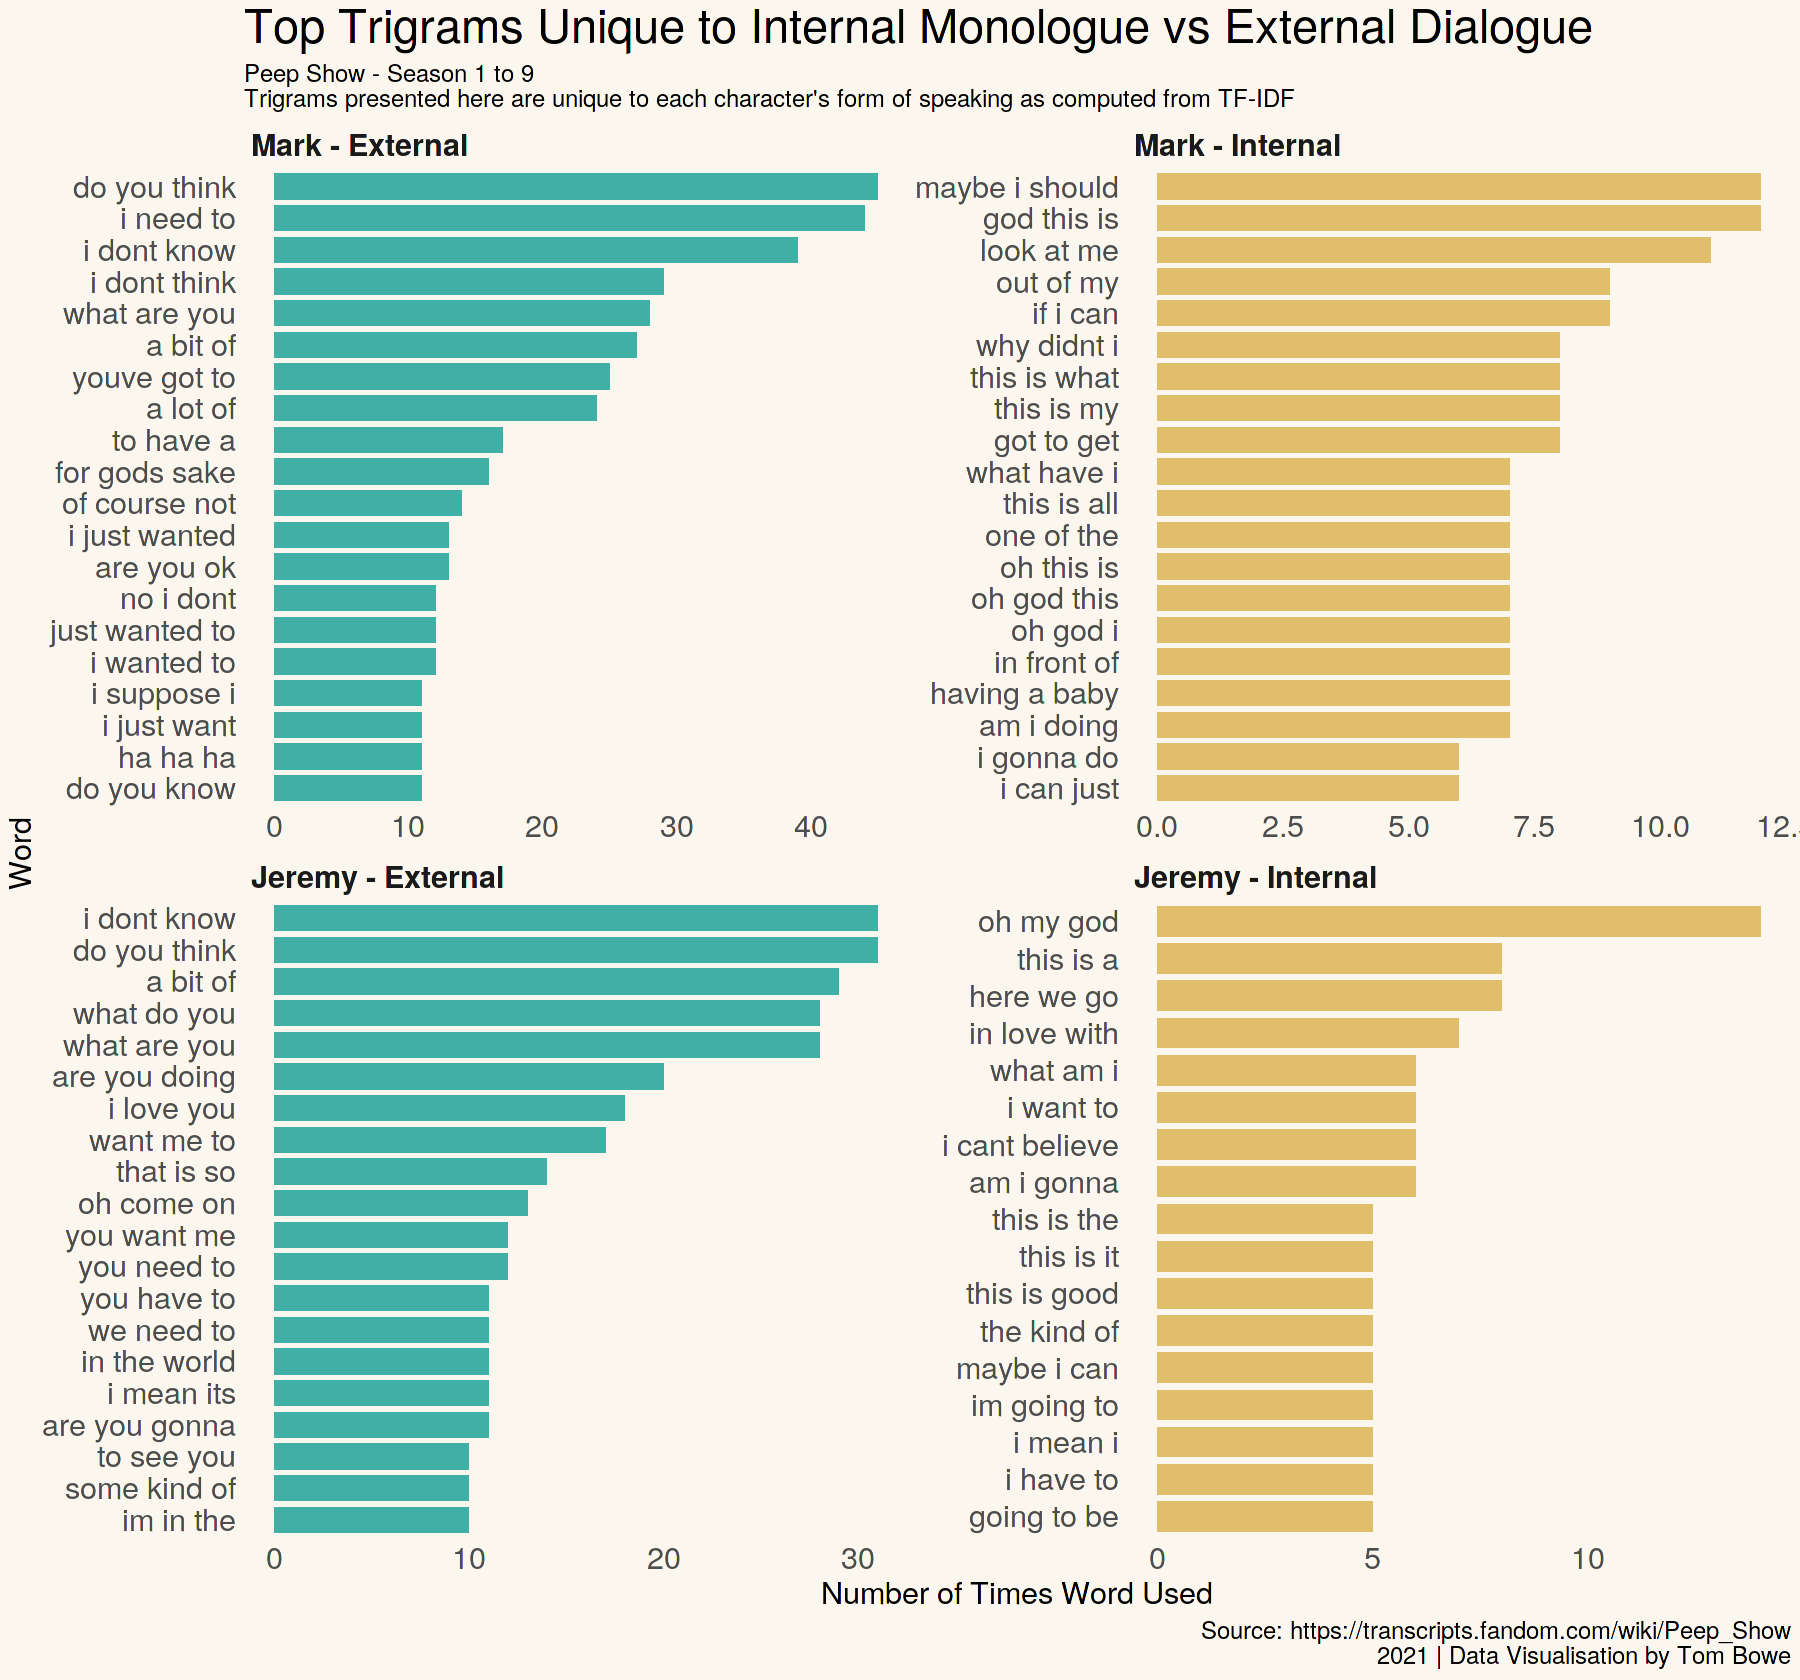

In [70]:
trigrams <-
  rbind(trigrams_mark_int,
        trigrams_mark_ext,
        trigrams_jez_int,
        trigrams_jez_ext) %>%
  mutate(category = paste(character, dialogue_type, sep = " - ")) %>%
  bind_tf_idf(word, category, freq)

trigrams_jez_plt_int <-
  subset(trigrams, category == "Jeremy - Internal") %>%
  arrange(desc(tf_idf)) %>% slice(1:20)
trigrams_jez_plt_ext <-
  subset(trigrams, category == "Jeremy - External") %>%
  arrange(desc(tf_idf)) %>% slice(1:20)
trigrams_mark_plt_int <-
  subset(trigrams, category == "Mark - Internal") %>%
  arrange(desc(tf_idf)) %>% slice(1:20)
trigrams_mark_plt_ext <-
  subset(trigrams, category == "Mark - External") %>%
  arrange(desc(tf_idf)) %>% slice(1:20)

trigrams_plt_all <-
  rbind(
    trigrams_jez_plt_int,
    trigrams_jez_plt_ext,
    trigrams_mark_plt_int,
    trigrams_mark_plt_ext
  ) %>%
  transform(category = factor(
    category,
    levels = c(
      "Mark - External",
      "Mark - Internal",
      "Jeremy - External",
      "Jeremy - Internal"
    )
  ))

# Visualise:
fig_height(14)
ggplot(trigrams_plt_all,
       aes(
         x = reorder_within(word, freq, category),
         y = freq,
         fill = dialogue_type
       )) +
  geom_bar(stat = "identity", width = 0.8) +
  scale_fill_manual(values = c("#40B0A6", "#E1BE6A")) +
  theme(legend.position = "none") +
  theme_tb() +
  scale_x_reordered() +
  facet_wrap(~ category, scales = "free") +
  coord_flip() +
  labs(
    y = "Number of Times Word Used",
    x = "Word",
    title = "Top Trigrams Unique to Internal Monologue vs External Dialogue",
    subtitle = "Peep Show - Season 1 to 9\nTrigrams presented here are unique to each character's form of speaking as computed from TF-IDF",
    caption = capt
  )

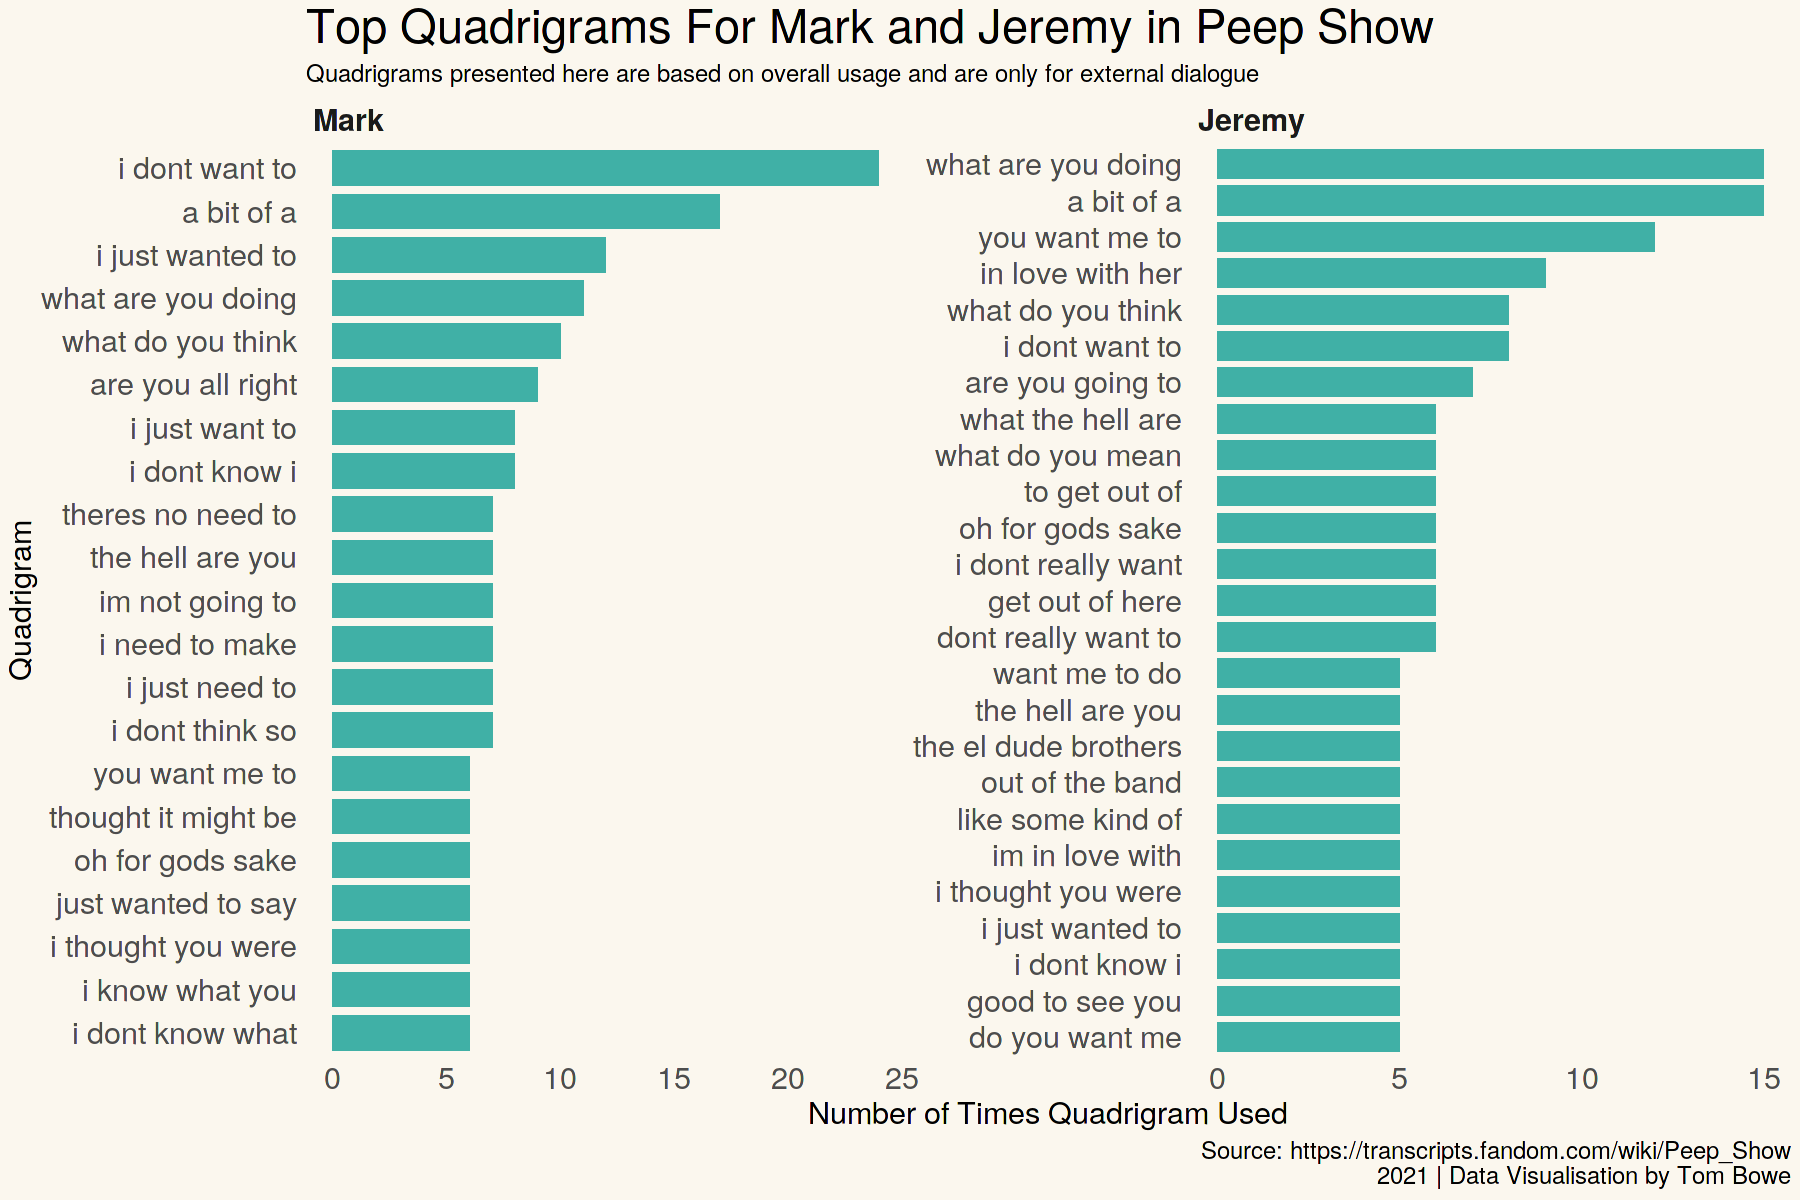

In [71]:
# Visualise:
fig_height(10)
ggplot(quadrigrams, aes(x = reorder_within(word, freq, character), y = freq)) +
  geom_bar(stat = "identity", width = 0.8, fill = "#40B0A6") +
  theme(legend.position = "none") +
  theme_tb() +
  scale_x_reordered() +
  facet_wrap( ~ character, scales = "free") +
  coord_flip() +
  labs(
    y = "Number of Times Quadrigram Used",
    x = "Quadrigram",
    title = "Top Quadrigrams For Mark and Jeremy in Peep Show",
    subtitle = "Quadrigrams presented here are based on overall usage and are only for external dialogue",
    caption = capt
  )